# Kết nối Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import math
import sys
import pickle

from scipy.stats import chi2_contingency, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

sys.path.append('/content/drive/MyDrive/Colab Notebooks/RPython/Model')
from func import *

import warnings
warnings.filterwarnings("ignore")

# Hàm lưu mô hình

In [ ]:
# Hàm lưu mô hình
def save_model(folder, model_name, saved_models):
    for fold, model in saved_models:  # saved_models phải là list chứa (fold, model)
        filename = f"/content/drive/MyDrive/Colab Notebooks/RPython/SavedModel/{folder}/{model_name}_fold_{fold}.pkl"
        with open(filename, "wb") as f:
            pickle.dump(model, f)

# Tải dữ liệu

In [ ]:
df_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RPython/Data/Listings.csv')
df = df_org.copy()
df.head()

id                                 name  host_id  host_name  \
0  49091    COZICOMFORT LONG TERM STAY ROOM 2   266763  Francesca   
1  50646      Pleasant Room along Bukit Timah   227796    Sujatha   
2  56334                          COZICOMFORT   266763  Francesca   
3  71609  Ensuite Room (Room 1 & 2) near EXPO   367042    Belinda   
4  71896      B&B  Room 1 near Airport & EXPO   367042    Belinda   

  neighbourhood_group neighbourhood  latitude  longitude     room_type  price  \
0        North Region     Woodlands   1.44255  103.79580  Private room     83   
1      Central Region   Bukit Timah   1.33235  103.78521  Private room     81   
2        North Region     Woodlands   1.44246  103.79667  Private room     69   
3         East Region      Tampines   1.34541  103.95712  Private room    206   
4         East Region      Tampines   1.34567  103.95963  Private room     94   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0             180                  1  2013-10-21               0.01   
1              90                 18  2014-12-26               0.28   
2               6                 20  2015-10-01               0.20   
3               1                 14  2019-08-11               0.15   
4               1                 22  2019-07-28               0.22   

   calculated_host_listings_count  availability_365  
0                               2               365  
1                               1               365  
2                               2               365  
3                               9               353  
4                               9               355

# EDA

## Xử lý chung

In [ ]:
overview_data(df)

                DataFrame Overview                
Shape: (7907, 16)
--------------------------------------------------
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7907 non-null   int64  
 1   name                            7905 non-null   object 
 2   host_id                         7907 non-null   int64  
 3   host_name                       7907 non-null   object 
 4   neighbourhood_group             7907 non-null   object 
 5   neighbourhood                   7907 non-null   object 
 6   latitude                        7907 non-null   float64
 7   longitude                       7907 non-null   float64
 8   room_type                       7907 non-null   object 
 9   price                           7907 non-null   int64  
 10  minimum_nights                

In [ ]:
cont_cols = df.select_dtypes(include="number").columns
df[cont_cols].describe()

id       host_id     latitude    longitude         price  \
count  7.907000e+03  7.907000e+03  7907.000000  7907.000000   7907.000000   
mean   2.338862e+07  9.114481e+07     1.314192   103.848787    169.332996   
std    1.016416e+07  8.190910e+07     0.030577     0.043675    340.187599   
min    4.909100e+04  2.366600e+04     1.243870   103.646560      0.000000   
25%    1.582180e+07  2.305808e+07     1.295795   103.835825     65.000000   
50%    2.470627e+07  6.344891e+07     1.311030   103.849410    124.000000   
75%    3.234850e+07  1.553811e+08     1.322110   103.872535    199.000000   
max    3.811276e+07  2.885676e+08     1.454590   103.973420  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count     7907.000000        7907.000000        5149.000000   
mean        17.510054          12.807386           1.043669   
std         42.094616          29.707746           1.285851   
min          1.000000           0.000000           0.010000   
25%          1.000000           0.000000           0.180000   
50%          3.000000           2.000000           0.550000   
75%         10.000000          10.000000           1.370000   
max       1000.000000         323.000000          13.000000   

       calculated_host_listings_count  availability_365  
count                     7907.000000       7907.000000  
mean                        40.607689        208.726318  
std                         65.135253        146.120034  
min                          1.000000          0.000000  
25%                          2.000000         54.000000  
50%                          9.000000        260.000000  
75%                         48.000000        355.000000  
max                        274.000000        365.000000

In [ ]:
cat_cols = df.select_dtypes(include="object").columns
df[cat_cols].describe()

name host_name  \
count                                                7905      7907   
unique                                               7457      1833   
top     Luxury hostel with in-cabin locker - Single mixed       Jay   
freq                                                   13       290   

       neighbourhood_group neighbourhood        room_type last_review  
count                 7907          7907             7907        5149  
unique                   5            43                3        1001  
top         Central Region       Kallang  Entire home/apt  2019-08-12  
freq                  6309          1043             4132         152

In [ ]:
df.drop(columns=["id", "host_id", "name", "host_name", "last_review","reviews_per_month"], inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df["price"] = df.pop("price")
df

neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0           North Region     Woodlands   1.44255  103.79580     Private room   
1         Central Region   Bukit Timah   1.33235  103.78521     Private room   
2           North Region     Woodlands   1.44246  103.79667     Private room   
3            East Region      Tampines   1.34541  103.95712     Private room   
4            East Region      Tampines   1.34567  103.95963     Private room   
...                  ...           ...       ...        ...              ...   
7901      Central Region    Queenstown   1.27973  103.78751  Entire home/apt   
7903      Central Region       Tanglin   1.29269  103.82623  Entire home/apt   
7904      Central Region       Kallang   1.31286  103.85996     Private room   
7905      Central Region  River Valley   1.29543  103.83801     Private room   
7906      Central Region  River Valley   1.29672  103.83325     Private room   

      minimum_nights  number_of_reviews  calculated_host_listings_count  \
0                180                  1                               2   
1                 90                 18                               1   
2                  6                 20                               2   
3                  1                 14                               9   
4                  1                 22                               9   
...              ...                ...                             ...   
7901               3                  0                              31   
7903               6                  0                              34   
7904              30                  0                               3   
7905              14                  0                               2   
7906              90                  0                               7   

      availability_365  price  
0                  365     83  
1                  365     81  
2                  365     69  
3                  353    206  
4                  355     94  
...                ...    ...  
7901                61    100  
7903               365    550  
7904               173     58  
7905                30     56  
7906               365     65  

[7906 rows x 10 columns]

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(df[col].value_counts().sort_index(ascending=True))
    print("===="*8)
# cat_cols = df.select_dtypes(include=['object']).columns
# cat_cols

neighbourhood_group
Central Region       6308
East Region           508
North Region          204
North-East Region     346
West Region           540
Name: count, dtype: int64
neighbourhood
Ang Mo Kio                   58
Bedok                       373
Bishan                       57
Bukit Batok                  65
Bukit Merah                 470
Bukit Panjang                34
Bukit Timah                 131
Central Water Catchment      34
Choa Chu Kang                63
Clementi                    102
Downtown Core               428
Geylang                     994
Hougang                     109
Jurong East                 118
Jurong West                 153
Kallang                    1043
Lim Chu Kang                  1
Mandai                        3
Marina South                  1
Marine Parade               171
Museum                       63
Newton                      134
Novena                      537
Orchard                     136
Outram                      477
Pasir Ris 

## Trực quan hoá dữ liệu

array([[<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'minimum_nights'}>],
       [<Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'calculated_host_listings_count'}>,
        <Axes: title={'center': 'availability_365'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >, <Axes: >]],
      dtype=object)

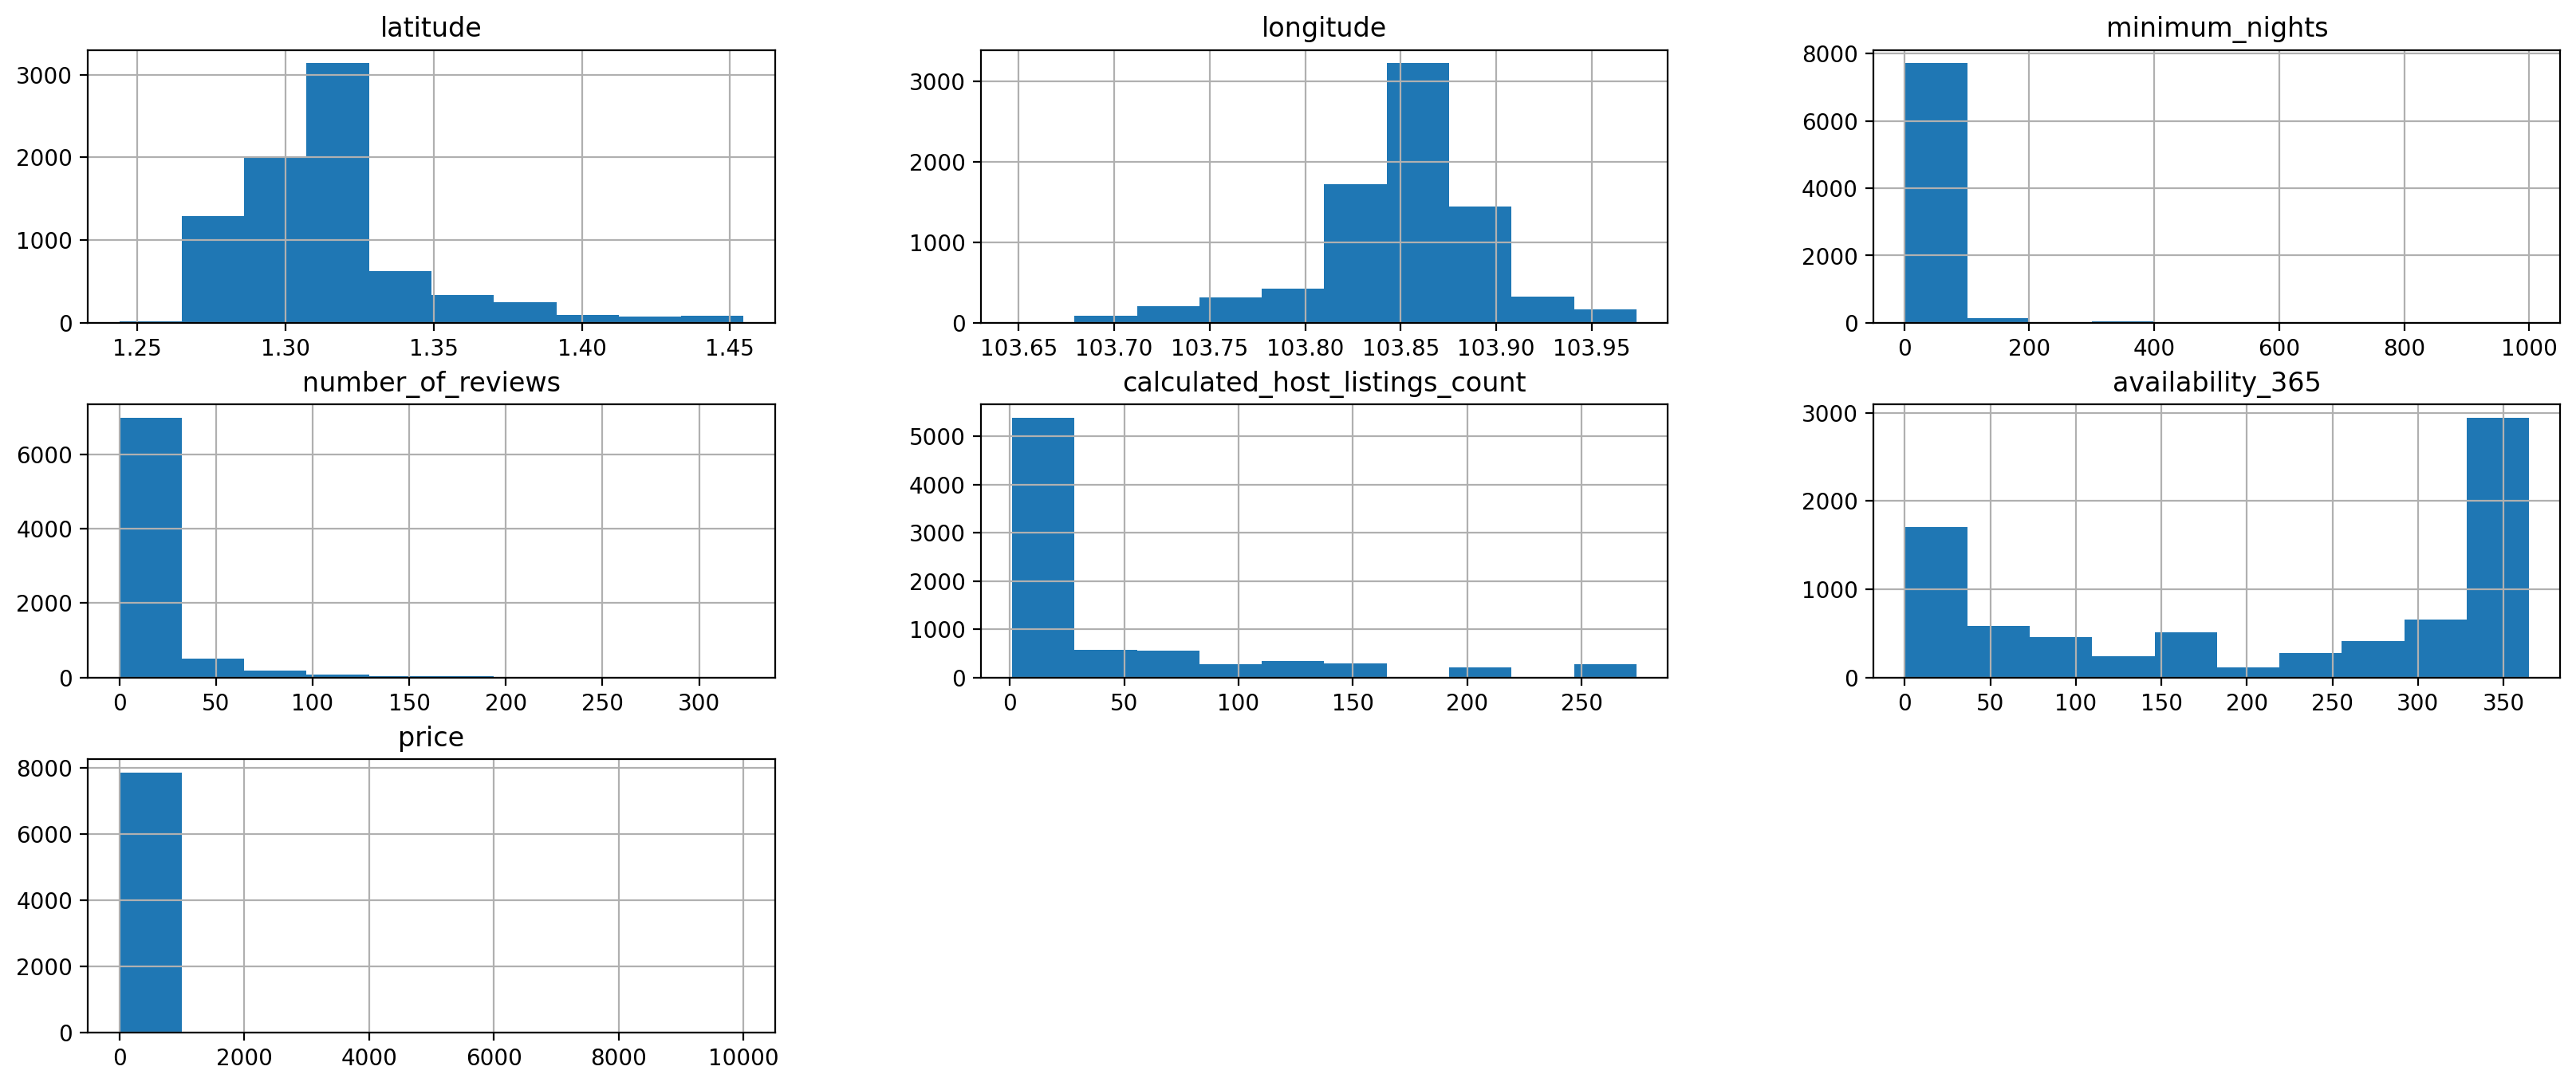

In [ ]:
plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 10
df.hist()

In [ ]:
cont_cols_ = ["latitude", "longitude", "minimum_nights", "number_of_reviews", "calculated_host_listings_count", "availability_365", "price"]
plt.rcParams["figure.figsize"] = (20, 12)
sns.pairplot(df[cont_cols_])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

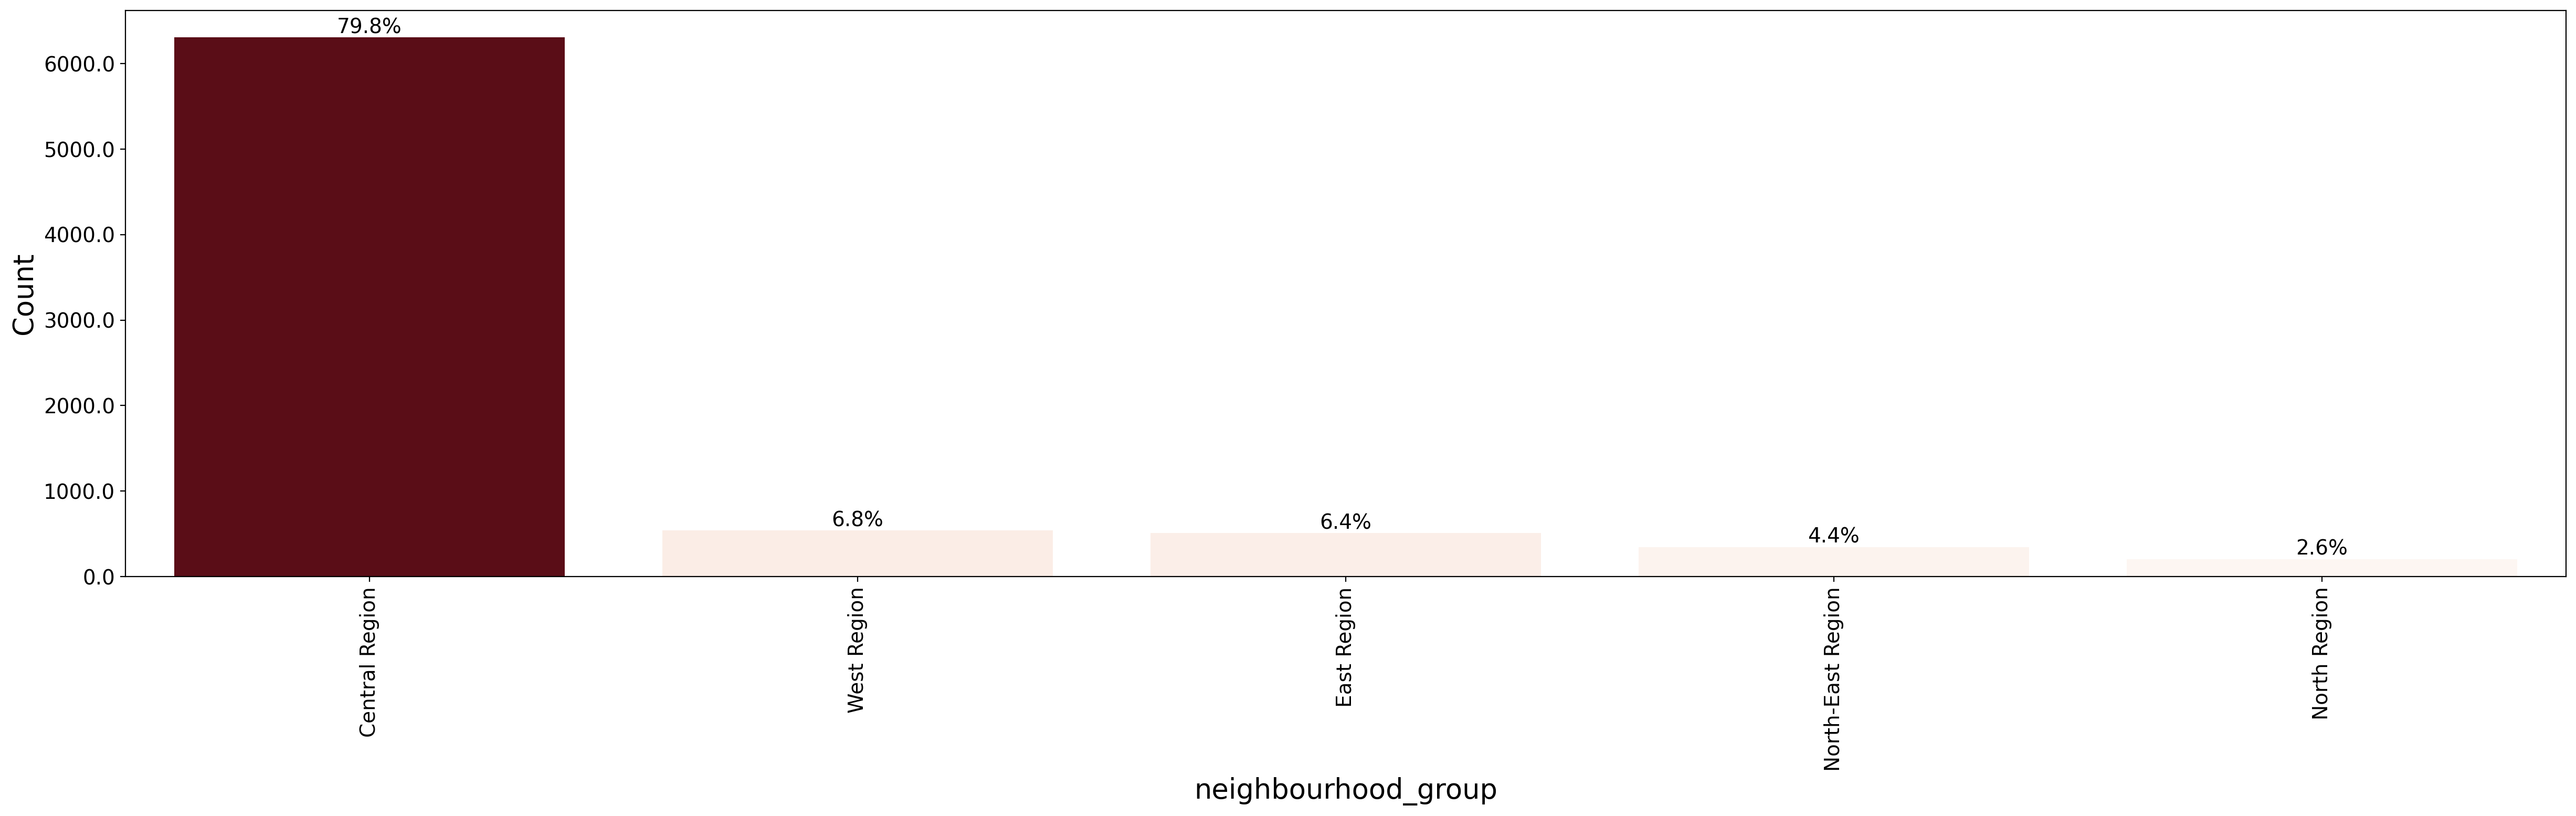

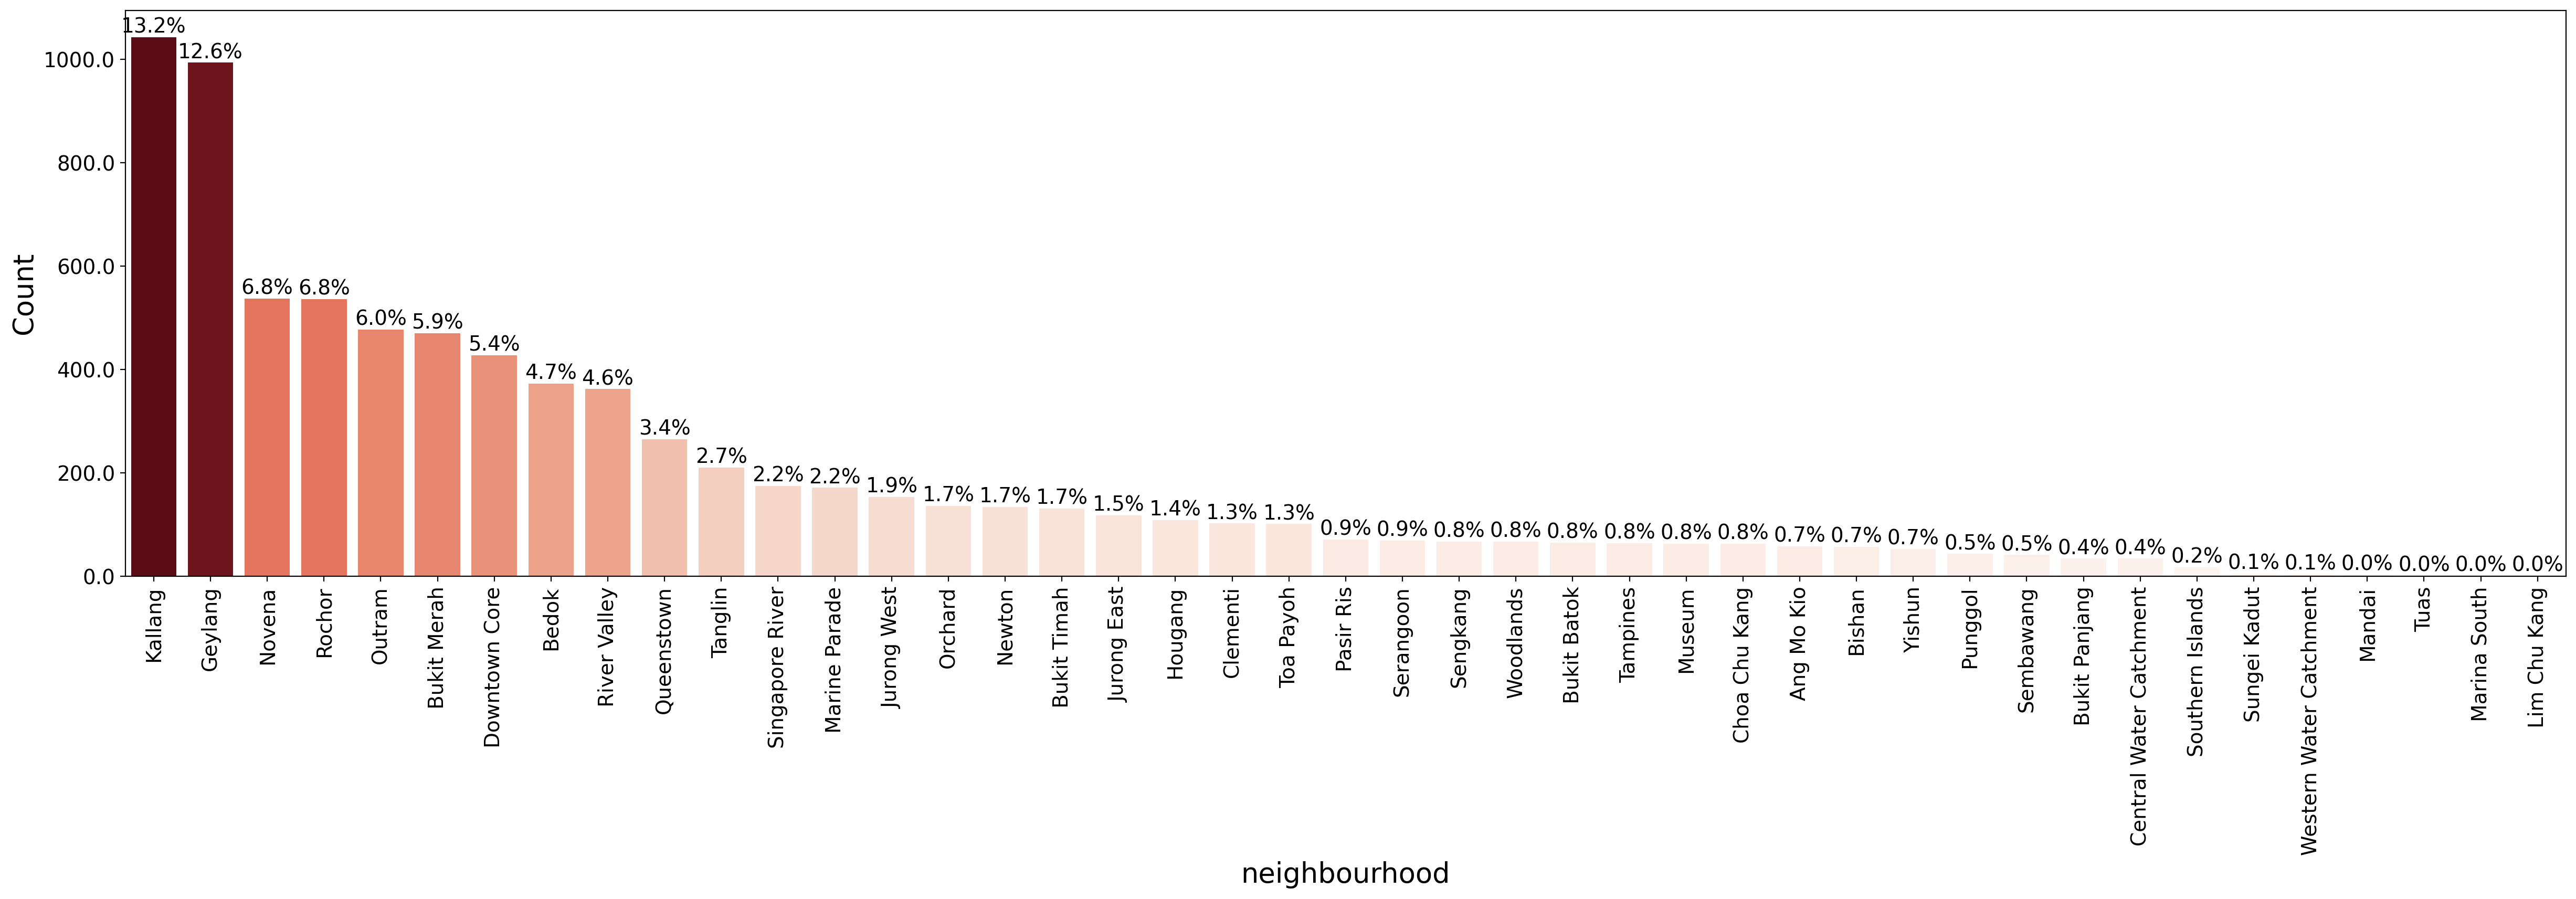

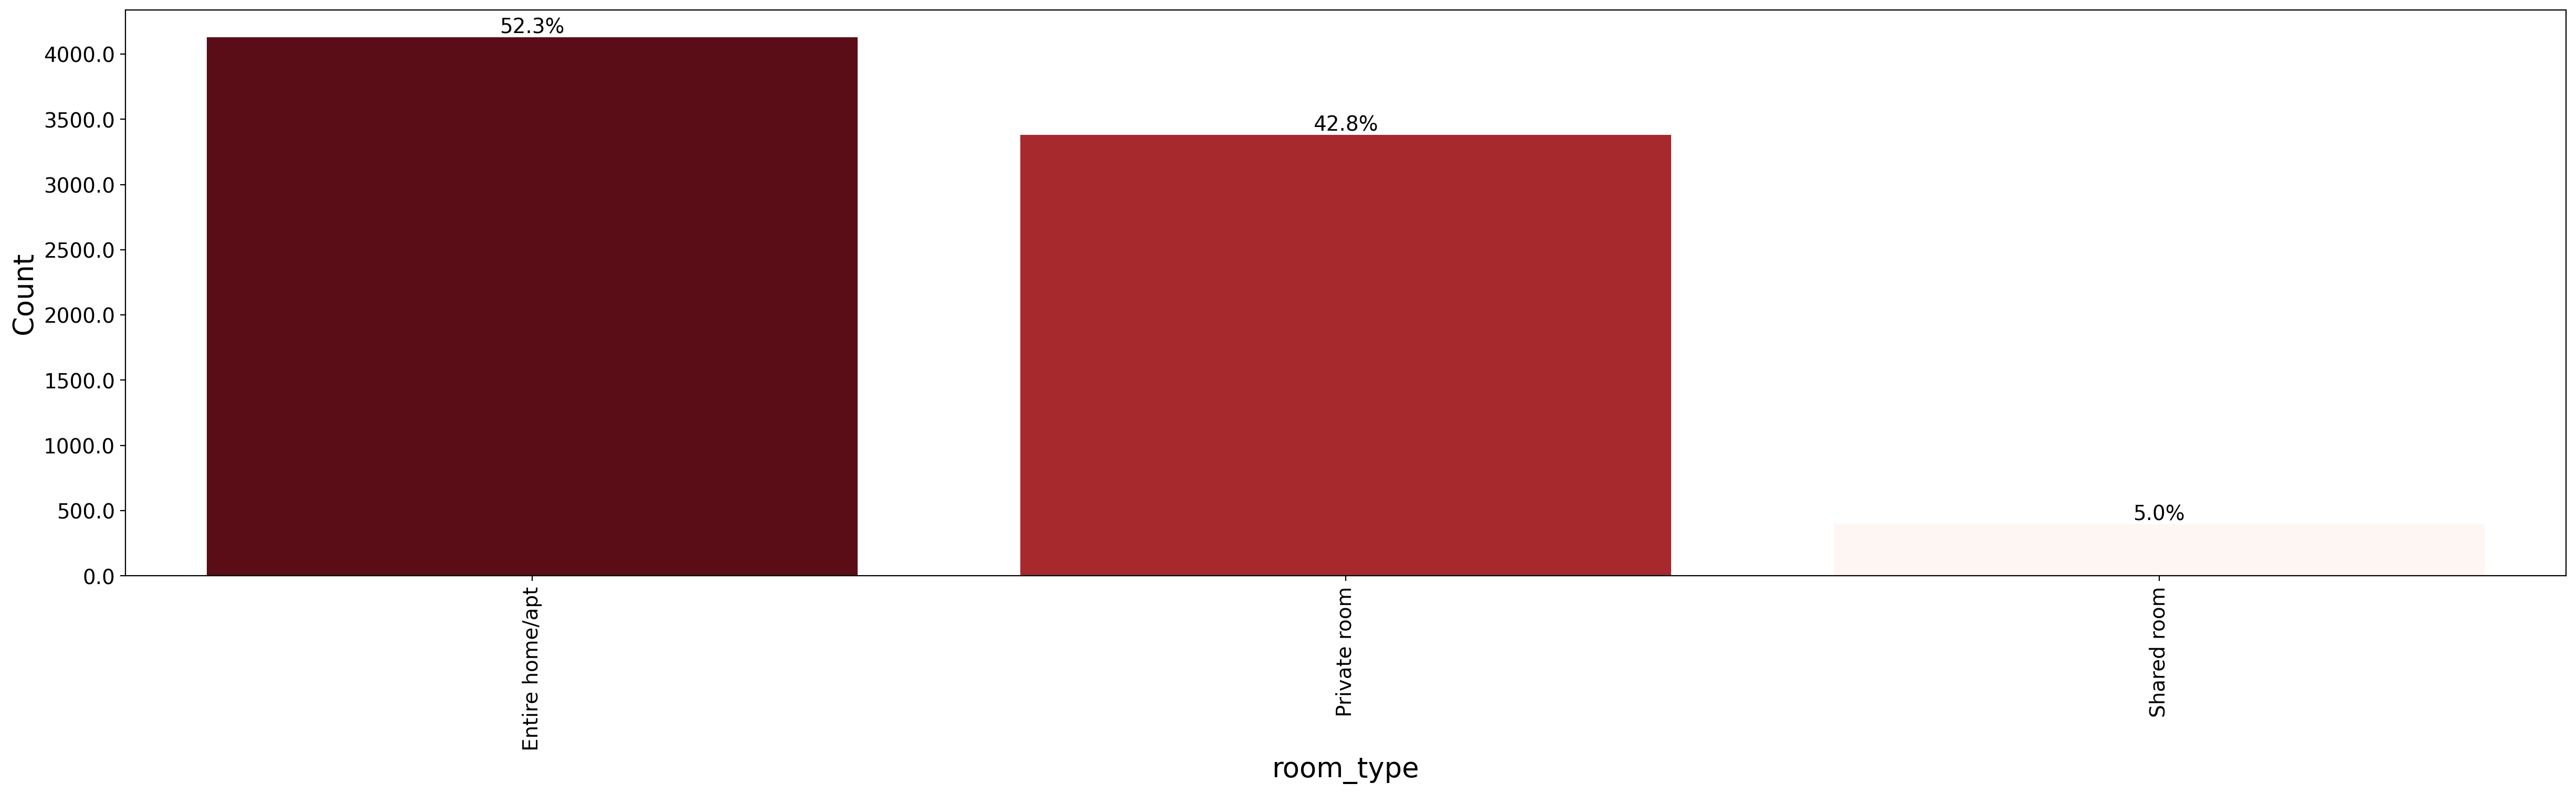

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns
for c in cat_cols:
    plot_category_distribution(df, c, figsize=(30, 7), labelsize=14)

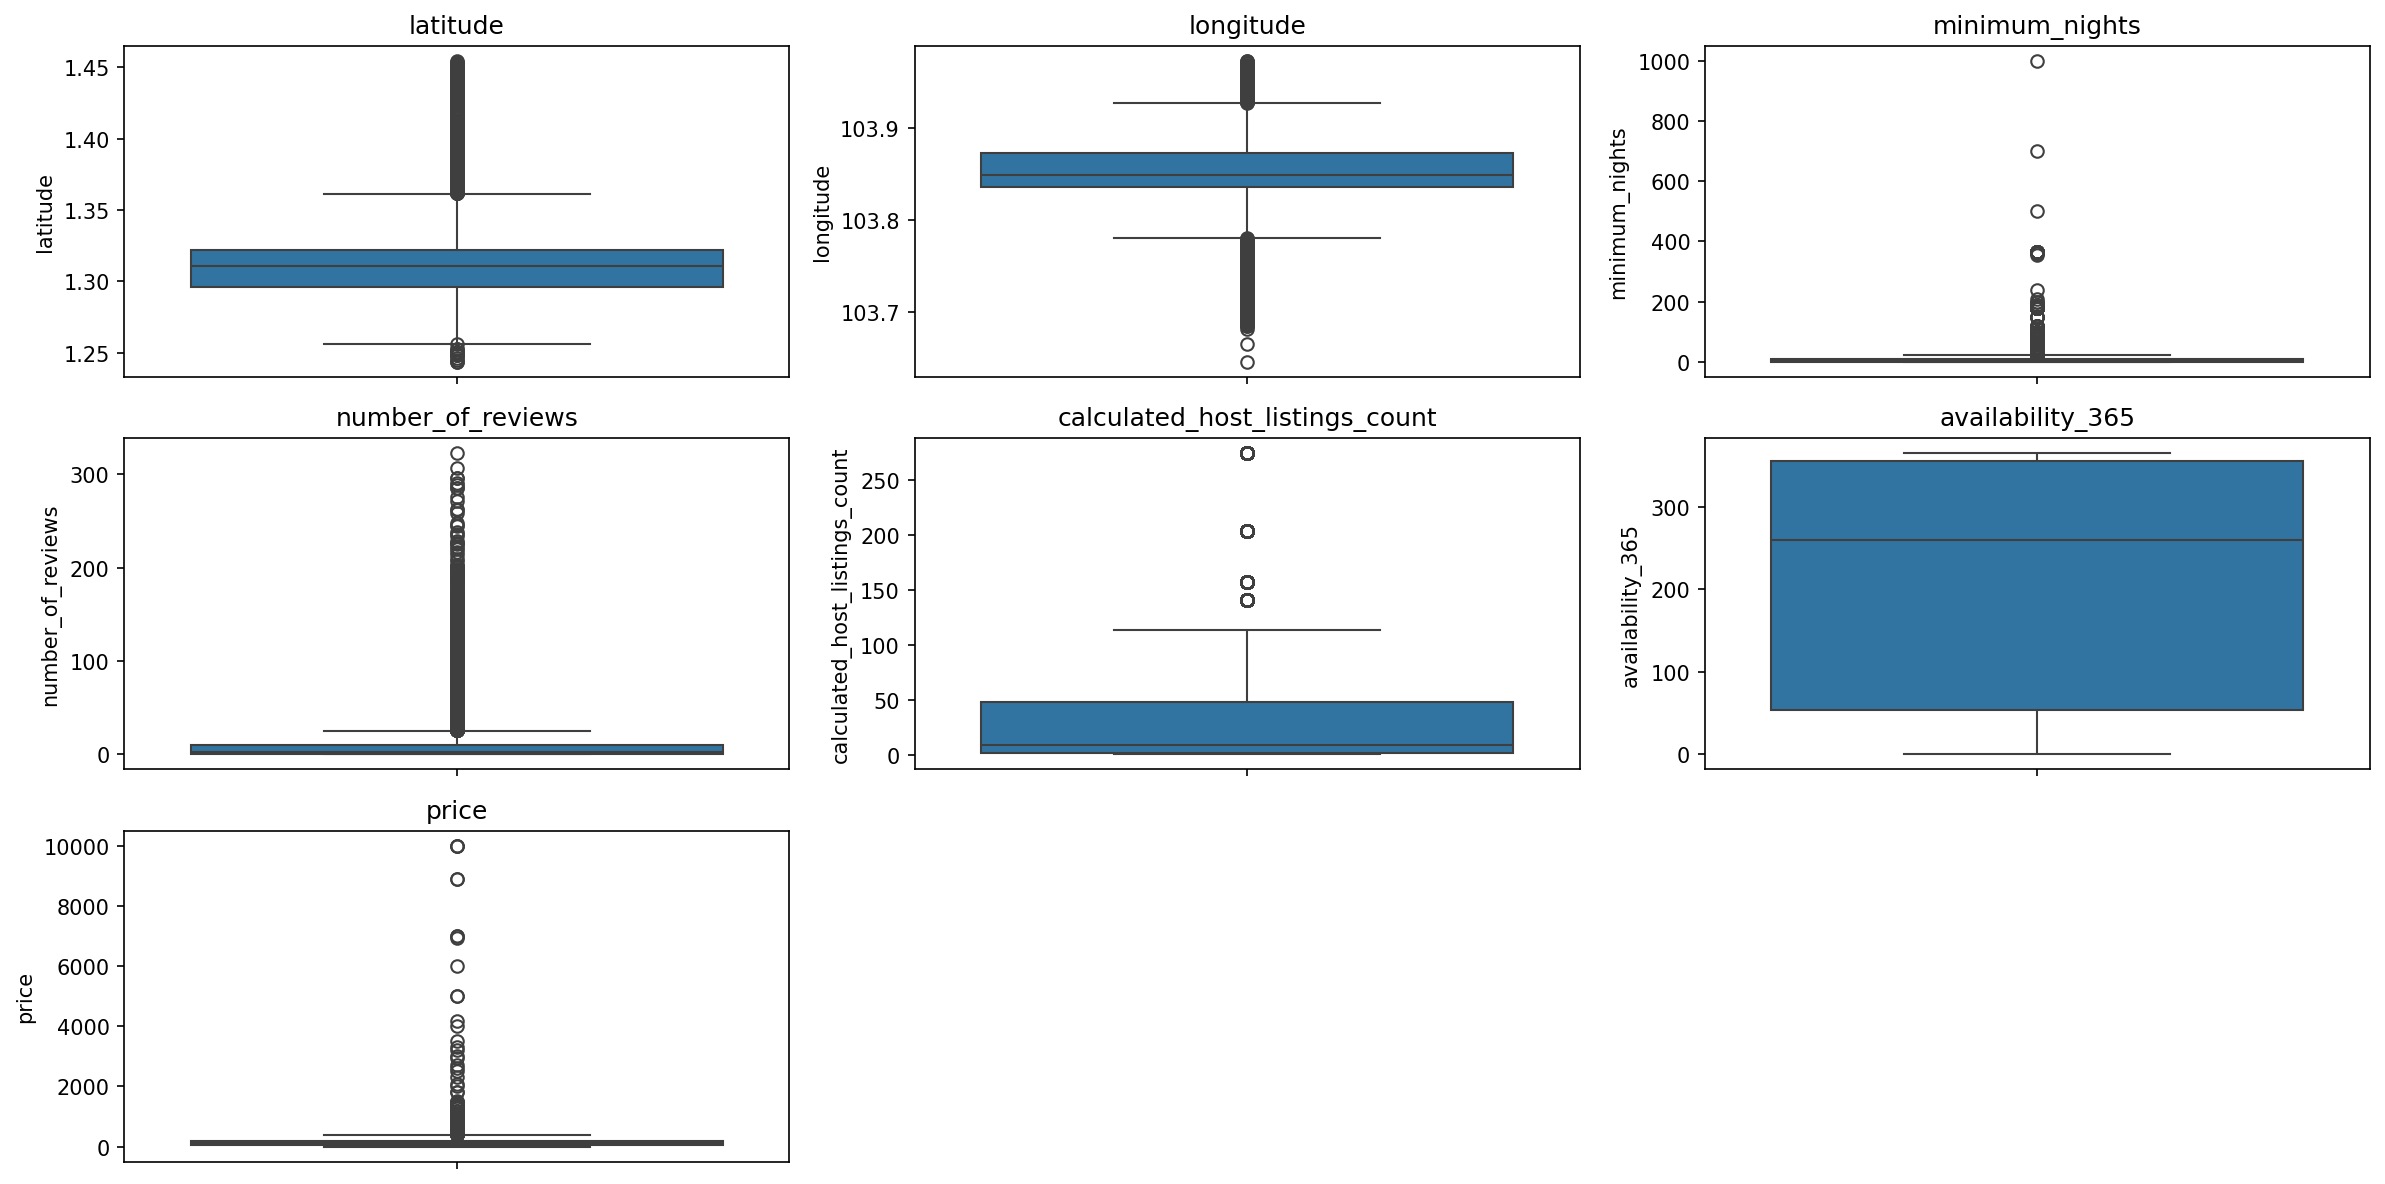

Tổng số outlier là 4036, tỷ lệ 51.05%


In [ ]:
# cont_cols_: Kilometers_Driven, Mileage, Engine, Power, Price
cont_cols_ = ["latitude", "longitude", "minimum_nights", "number_of_reviews", "calculated_host_listings_count", "availability_365", "price"]
boxplots(df, cont_cols_, 3)
df_ol = find_outliers(df, cont_cols_)
print(f"Tổng số outlier là {len(df_ol)}, tỷ lệ {round(len(df_ol) / len(df) * 100, 2)}%")

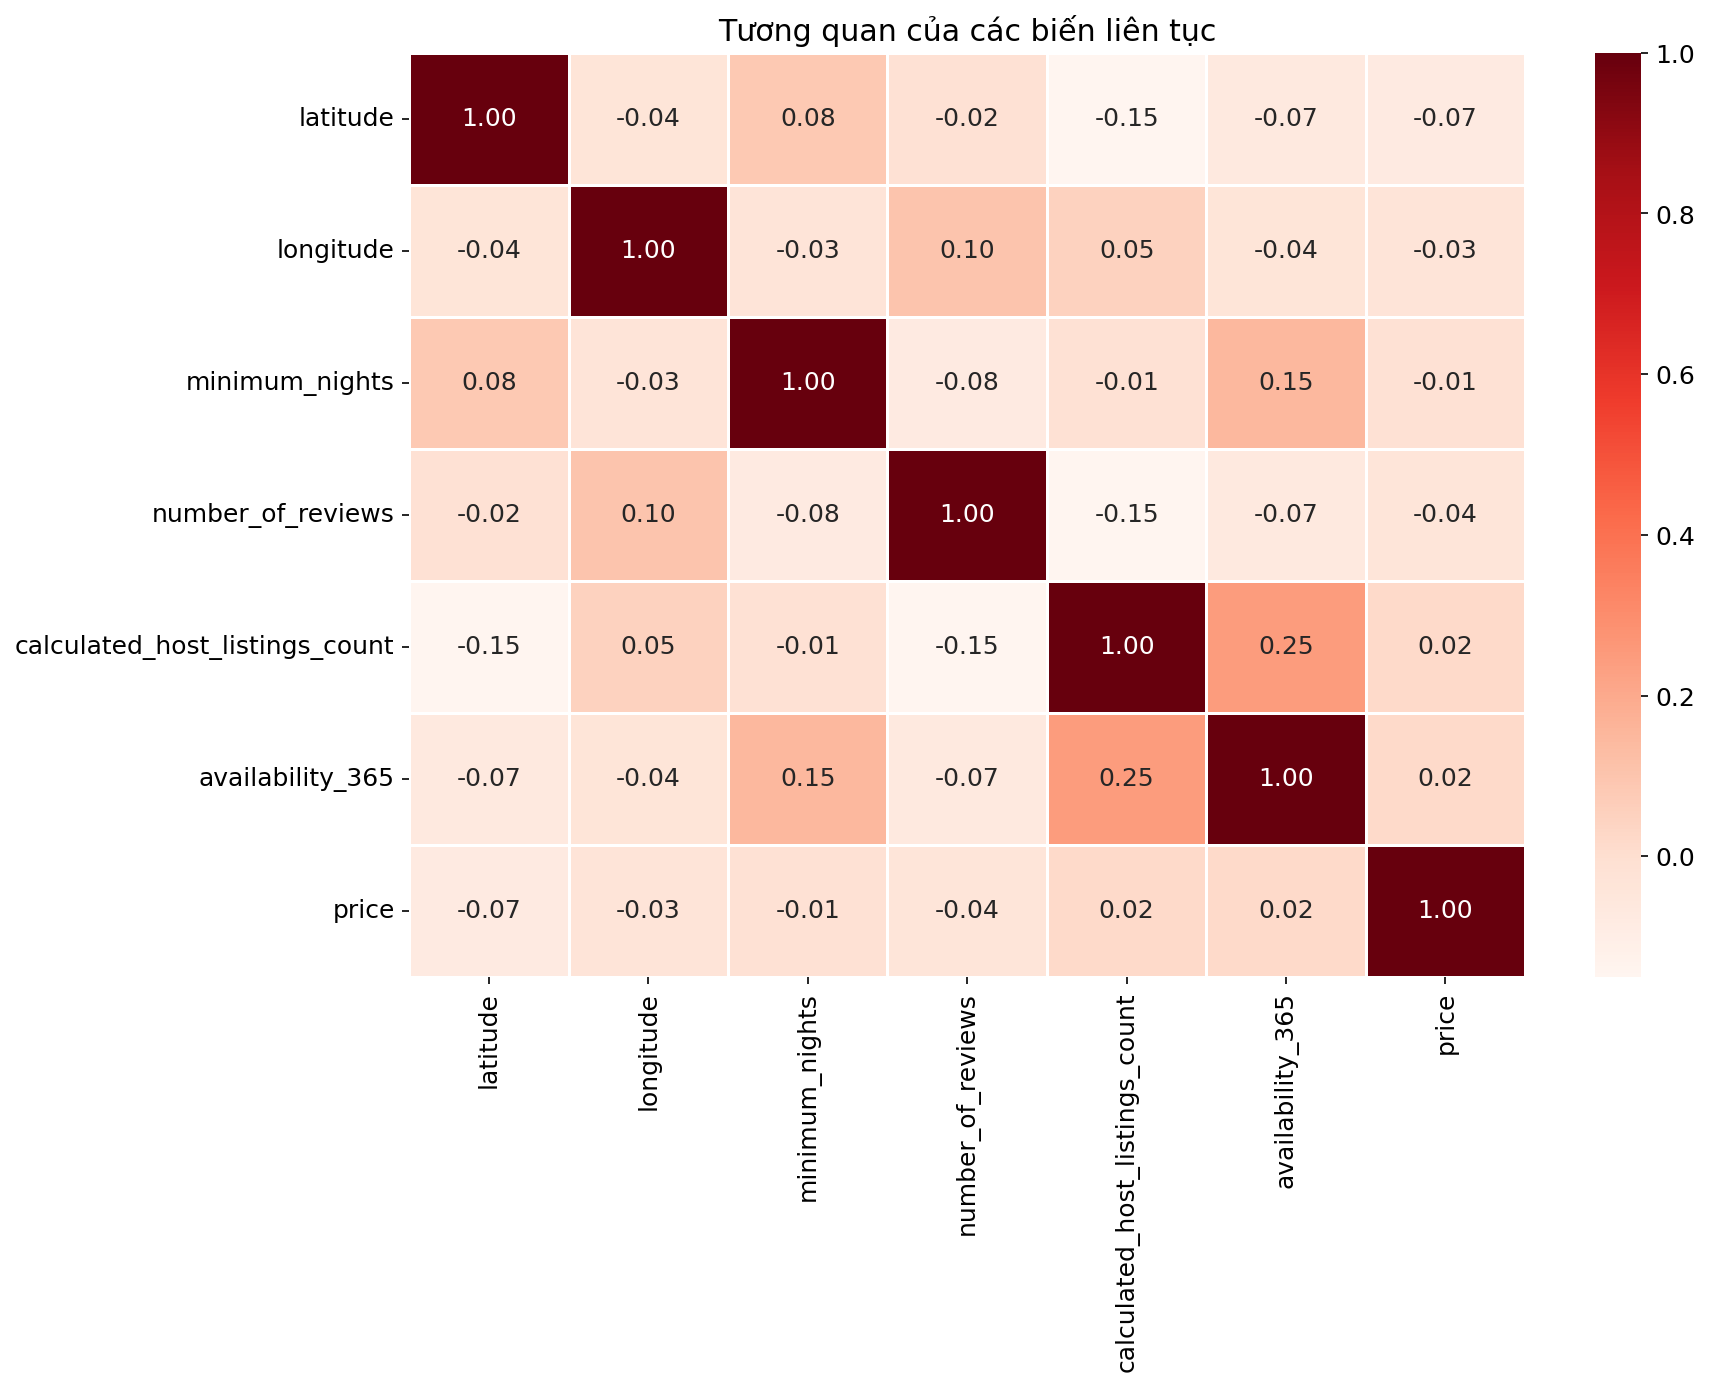

In [ ]:
# Kiểm tra tương quan của các biến liên tục
continuous_vars = df.select_dtypes(include=["number"]).columns
corr_matrix = df[continuous_vars].corr()

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 12
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Reds", linewidths=0.5)
plt.title("Tương quan của các biến liên tục")
plt.show()

In [ ]:
anova_test(df, "price")

Variable  F-statistic  p-value Impact
0  neighbourhood_group        6.708      0.0    Yes
1        neighbourhood       39.030      0.0    Yes
2            room_type      131.716      0.0    Yes

## Mã hoá dữ liệu

### neighbourhood_group

In [ ]:
df_ol_neighbourhood_group = df.groupby("neighbourhood_group", as_index=False)["price"].mean()
df_ol_neighbourhood_group.rename(columns={"price": "Average_Price"}, inplace=True)
df_ol_neighbourhood_group.sort_values(by="Average_Price", ascending=False)

neighbourhood_group  Average_Price
0      Central Region     176.641566
4         West Region     175.974074
1         East Region     142.503937
2        North Region     110.779412
3   North-East Region      99.838150

In [ ]:
neighbourhood_group_mapping = {
    "Central Region": 4,
    "West Region": 4,
    "East Region": 3,
    "North Region": 2,
    "North-East Region": 1
}
df["neighbourhood_group"] = df["neighbourhood_group"].map(neighbourhood_group_mapping)

### neighbourhood

In [ ]:
df_ol_neighbourhood = df.groupby("neighbourhood", as_index=False)["price"].mean()
df_ol_neighbourhood.rename(columns={"price": "Average_Price"}, inplace=True)
df_ol_neighbourhood.sort_values(by="Average_Price", ascending=False)

neighbourhood  Average_Price
39                     Tuas   10000.000000
34         Southern Islands    1893.764706
18             Marina South     419.000000
5             Bukit Panjang     365.352941
23                  Orchard     291.029412
20                   Museum     236.317460
3               Bukit Batok     206.169231
10            Downtown Core     205.394860
37                  Tanglin     201.276190
33          Singapore River     189.937143
29                   Rochor     188.792910
21                   Newton     188.746269
7   Central Water Catchment     184.852941
13              Jurong East     184.720339
22                   Novena     177.441341
9                  Clementi     170.705882
2                    Bishan     170.508772
15                  Kallang     166.162991
28             River Valley     164.977901
11                  Geylang     161.598592
1                     Bedok     158.630027
6               Bukit Timah     153.969466
38                Toa Payoh     153.237624
4               Bukit Merah     151.442553
24                   Outram     145.937107
19            Marine Parade     145.818713
27               Queenstown     140.516981
12                  Hougang     124.321101
42                   Yishun     121.584906
35             Sungei Kadut     111.200000
0                Ang Mo Kio     103.448276
36                 Tampines     100.390625
25                Pasir Ris      95.746479
8             Choa Chu Kang      93.317460
32                Serangoon      91.173913
14              Jurong West      91.045752
30                Sembawang      88.268293
26                  Punggol      85.744186
41                Woodlands      81.492537
31                 Sengkang      74.850746
16             Lim Chu Kang      65.000000
17                   Mandai      56.666667
40  Western Water Catchment      46.250000

In [ ]:
def encode_price(avg_price):
    return int(avg_price // 10) + 1

# Thêm cột mã hóa vào df_ol_neighbourhood
df_ol_neighbourhood["Encoded_Price"] = df_ol_neighbourhood["Average_Price"].apply(encode_price)

# Ánh xạ giá trị mã hóa vào df_selected
df["neighbourhood"] = df["neighbourhood"].map(df_ol_neighbourhood.set_index("neighbourhood")["Encoded_Price"])

### room_type

In [ ]:
df_avg_room_type = df.groupby("room_type", as_index=False)["price"].mean()
df_avg_room_type.rename(columns={"price": "Average_Price"}, inplace=True)
df_avg_room_type.sort_values(by="Average_Price", ascending=False)

room_type  Average_Price
0  Entire home/apt     227.029049
1     Private room     110.938480
2      Shared room      65.675127

In [ ]:
room_type_mapping = {
    "Entire home/apt": 3,
    "Private room": 2,
    "Shared room": 1,
}
df["room_type"] = df["room_type"].map(room_type_mapping)

# Định nghĩa hàm

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def decisiontree_model(df, independent, target, max_depth=5, min_samples_split=5, min_samples_leaf=2, n_splits=5):
    """
    Huấn luyện mô hình Decision Tree Regression với K-Fold Cross Validation.
    """
    X = df[independent].values
    y = df[target].values

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = []
    saved_models = []
    feature_importance_list = []

    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Huấn luyện mô hình
        model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
        model.fit(X_train, y_train)
        saved_models.append((fold, model))

        # Lưu Feature Importance (làm tròn đến 4 chữ số thập phân)
        feature_importance_list.append(pd.Series(
            np.round(model.feature_importances_, 4),
            index=independent,
            name=f"Fold {fold}"
        ))

        # Dự đoán
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Tính các metric
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Tính MAPE (thay giá trị 0 bằng 0.01 để tránh lỗi chia 0)
        train_mape = np.mean(np.abs((y_train - y_train_pred) / np.where(y_train == 0, 1, y_train))) * 100
        test_mape = np.mean(np.abs((y_test - y_test_pred) / np.where(y_test == 0, 1, y_test))) * 100

        # Lưu kết quả
        results.append([
            fold,
            round(train_mae, 2), round(test_mae, 2),
            round(train_rmse, 2), round(test_rmse, 2),
            round(train_mape, 2), round(test_mape, 2)
        ])

    # Tạo DataFrame Feature Importance
    feature_importance_df = pd.DataFrame(feature_importance_list)

    # Thêm dòng trung bình (mean), làm tròn đến 4 chữ số
    feature_importance_df.loc["Mean"] = feature_importance_df.mean().round(4)

    # DataFrame kết quả
    df_results = pd.DataFrame(results, columns=[
        "Fold", "Train MAE", "Test MAE", "Train RMSE", "Test RMSE",
        "Train MAPE", "Test MAPE"
    ])

    mean_values = df_results.mean(numeric_only=True).round(2)
    mean_values["Fold"] = "Mean"
    df_results = pd.concat([df_results, mean_values.to_frame().T], ignore_index=True)

    df_results.set_index("Fold", inplace=True)

    return df_results, saved_models, feature_importance_df

def randomforest_model(df, independent, target, n_estimators, max_depth=5, min_samples_split=5, min_samples_leaf=2, n_splits=5):
    """
    Huấn luyện mô hình Random Forest Regression với K-Fold Cross Validation.
    """
    X = df[independent].values
    y = df[target].values

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = []
    saved_models = []
    feature_importance_list = []

    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Huấn luyện mô hình
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
        model.fit(X_train, y_train)
        saved_models.append((fold, model))

        # Lưu Feature Importance (làm tròn đến 4 chữ số thập phân)
        feature_importance_list.append(pd.Series(
            np.round(model.feature_importances_, 4),
            index=independent,
            name=f"Fold {fold}"
        ))

        # Dự đoán
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Tính các metric
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Tính MAPE (thay giá trị 0 bằng 0.01 để tránh lỗi chia 0)
        train_mape = np.mean(np.abs((y_train - y_train_pred) / np.where(y_train == 0, 1, y_train))) * 100
        test_mape = np.mean(np.abs((y_test - y_test_pred) / np.where(y_test == 0, 1, y_test))) * 100

        # Lưu kết quả
        results.append([
            fold,
            round(train_mae, 2), round(test_mae, 2),
            round(train_rmse, 2), round(test_rmse, 2),
            round(train_mape, 2), round(test_mape, 2)
        ])

    # Tạo DataFrame Feature Importance
    feature_importance_df = pd.DataFrame(feature_importance_list)

    # Thêm dòng trung bình (mean), làm tròn đến 4 chữ số
    feature_importance_df.loc["Mean"] = feature_importance_df.mean().round(4)

    # DataFrame kết quả
    df_results = pd.DataFrame(results, columns=[
        "Fold", "Train MAE", "Test MAE", "Train RMSE", "Test RMSE",
        "Train MAPE", "Test MAPE"
    ])

    mean_values = df_results.mean(numeric_only=True).round(2)
    mean_values["Fold"] = "Mean"
    df_results = pd.concat([df_results, mean_values.to_frame().T], ignore_index=True)

    df_results.set_index("Fold", inplace=True)

    return df_results, saved_models, feature_importance_df

# Mô hình có outlier

## Decision Tree

In [ ]:
independent = df.columns[df.columns != "price"].tolist()
dependent = "price"

df_results, saved_models, feature_importance_df = decisiontree_model(df, independent, dependent, max_depth=5, min_samples_split=3, n_splits=5) # Các chỉ số max_depth, min_samples_split ngẫu nhiên
save_model("DecisionTree", "DT-OL-Random", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE
Fold                                                             
1        89.44    83.22     306.49    228.21      76.31     74.31
2        78.36    100.5     230.96    415.64      67.75     64.52
3        88.59    89.95     281.41    364.44      71.46     96.62
4        77.38   109.38     248.23    478.33      69.21      71.4
5        85.59    83.32     289.37    284.85      72.14     72.55
Mean     83.87    93.27     271.29    354.29      71.37     75.88

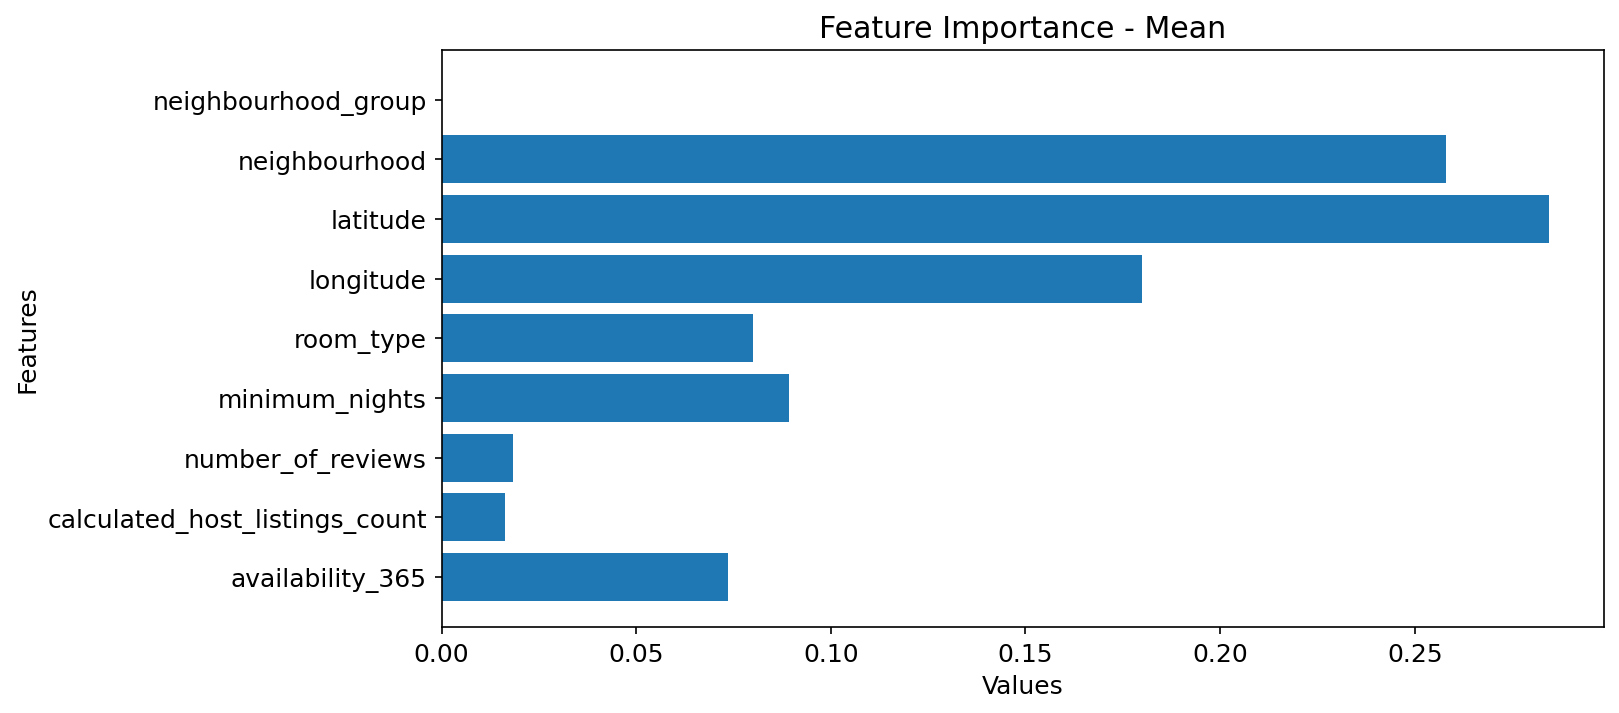

neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
Fold 1                  0.0         0.3503    0.1260     0.3712     0.0693   
Fold 2                  0.0         0.2917    0.2468     0.0273     0.0679   
Fold 3                  0.0         0.3168    0.3057     0.0002     0.0960   
Fold 4                  0.0         0.0289    0.6292     0.1472     0.1079   
Fold 5                  0.0         0.3030    0.1144     0.3539     0.0595   
Mean                    0.0         0.2581    0.2844     0.1800     0.0801   

        minimum_nights  number_of_reviews  calculated_host_listings_count  \
Fold 1          0.0204             0.0088                          0.0000   
Fold 2          0.3359             0.0274                          0.0001   
Fold 3          0.0244             0.0409                          0.0099   
Fold 4          0.0541             0.0079                          0.0001   
Fold 5          0.0116             0.0065                          0.0717   
Mean            0.0893             0.0183                          0.0164   

        availability_365  
Fold 1            0.0539  
Fold 2            0.0030  
Fold 3            0.2062  
Fold 4            0.0247  
Fold 5            0.0795  
Mean              0.0735

In [ ]:
plot_feature_importance(feature_importance_df, row_index=5)
feature_importance_df

## Random Forest

In [ ]:
independent = df.columns[df.columns != "price"].tolist()
dependent = "price"

df_results, saved_models, feature_importance_df = randomforest_model(df, independent, dependent, n_estimators=2, max_depth=5, min_samples_split=3, n_splits=5) # Các chỉ số n_estimators, max_depth, min_samples_split ngẫu nhiên
save_model("RandomForest", "RF-OL-Random", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE
Fold                                                             
1        88.48    84.05     303.14    248.95      74.41     73.37
2        80.57    97.88     287.78    418.17      64.08     59.49
3        88.92    89.49     301.39    374.52      72.45     95.66
4        80.41   105.96     273.99    434.23      69.29     69.76
5        85.89    77.18     303.57    202.84      69.77     64.03
Mean     84.85    90.91     293.97    335.74       70.0     72.46

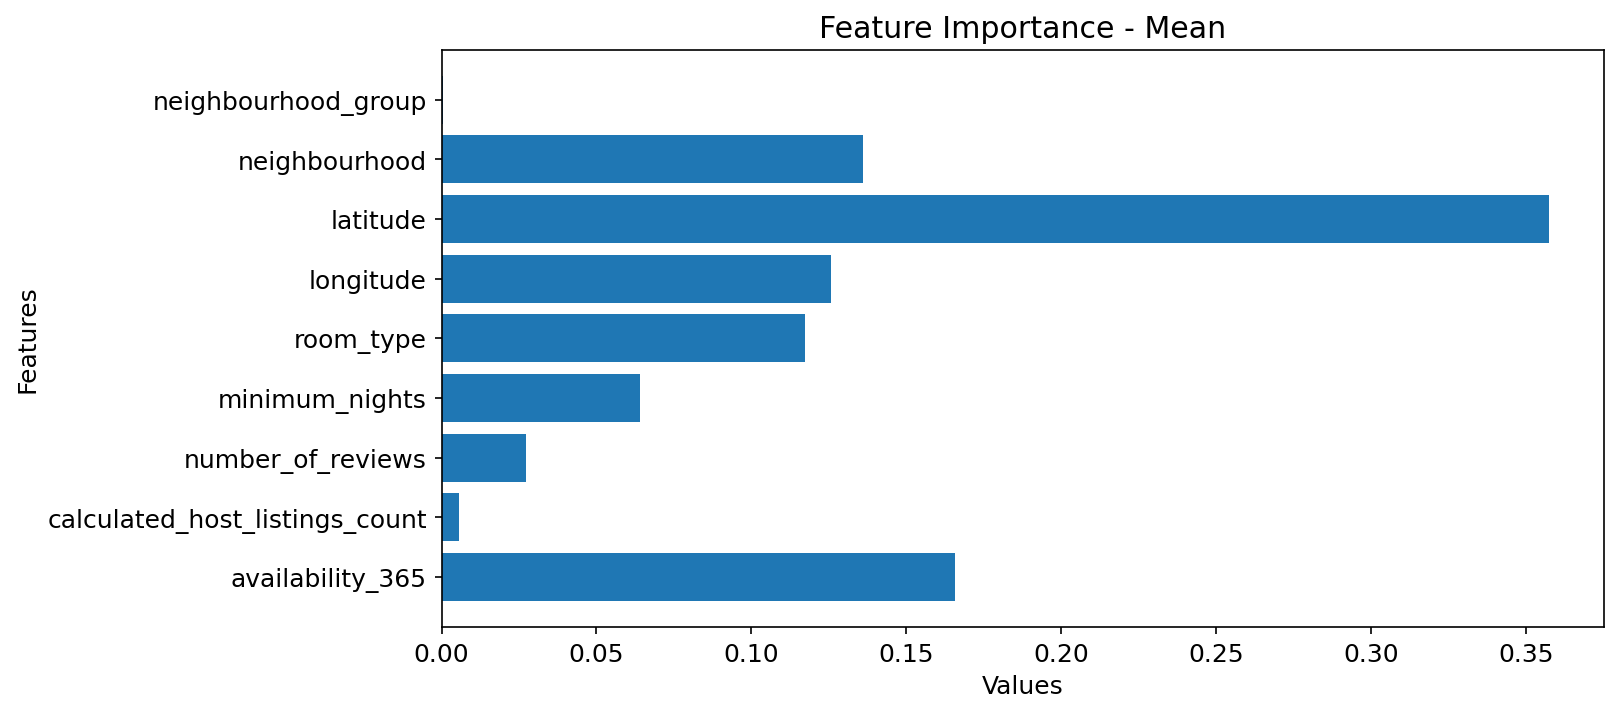

neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
Fold 1               0.0000         0.2558    0.1400     0.2577     0.0566   
Fold 2               0.0000         0.0210    0.5581     0.0038     0.1711   
Fold 3               0.0000         0.1162    0.4172     0.0025     0.0510   
Fold 4               0.0001         0.1581    0.2448     0.1703     0.2123   
Fold 5               0.0025         0.1297    0.4271     0.1937     0.0958   
Mean                 0.0005         0.1362    0.3574     0.1256     0.1174   

        minimum_nights  number_of_reviews  calculated_host_listings_count  \
Fold 1          0.0273             0.0055                          0.0118   
Fold 2          0.0587             0.0747                          0.0001   
Fold 3          0.0609             0.0299                          0.0056   
Fold 4          0.1501             0.0178                          0.0011   
Fold 5          0.0231             0.0092                          0.0093   
Mean            0.0640             0.0274                          0.0056   

        availability_365  
Fold 1            0.2452  
Fold 2            0.1124  
Fold 3            0.3166  
Fold 4            0.0453  
Fold 5            0.1094  
Mean              0.1658

In [ ]:
plot_feature_importance(feature_importance_df, row_index=5)
feature_importance_df

# Mô hình không có outlier

## Xử lý outlier

In [ ]:
# Hàm đếm tần số
def get_value_frequency(df, column):
    value_freq = df[column].value_counts().reset_index()
    value_freq.columns = [column, "frequency"]
    value_freq = value_freq.sort_values(by=column)
    return value_freq

### latitude

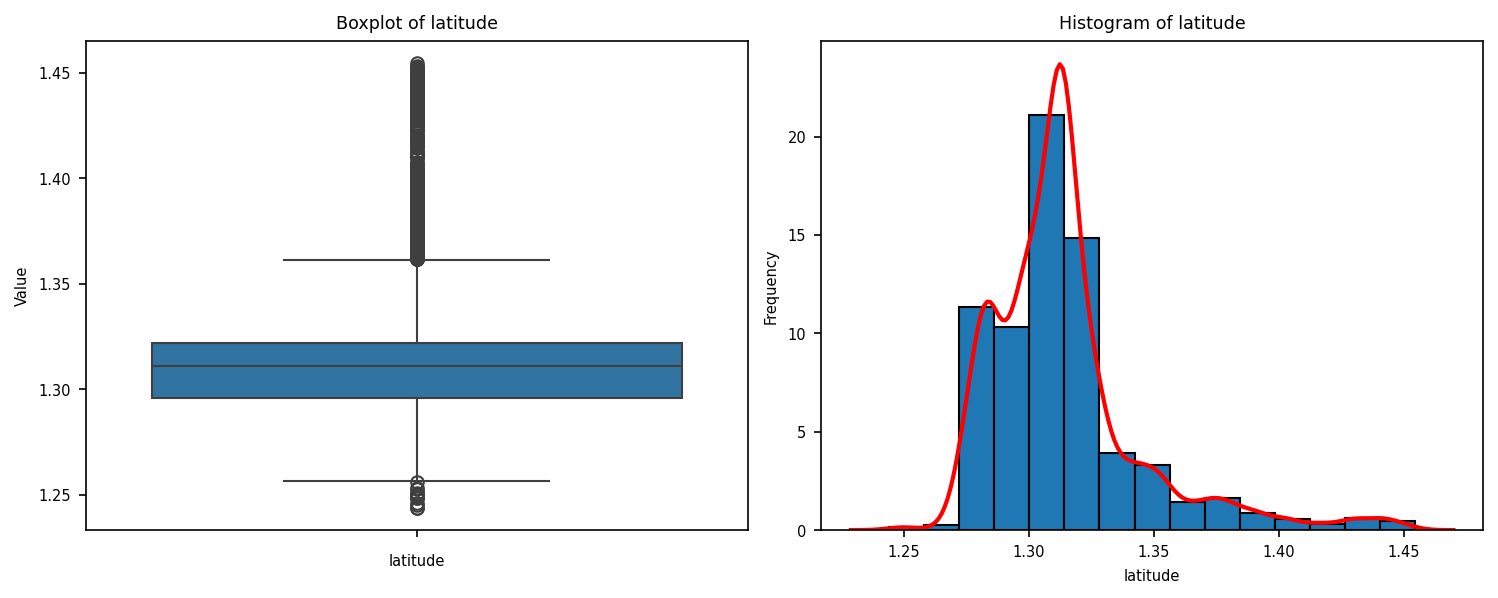

Tổng quan về outlier của cột latitude
Số lượng outlier: 632
Khoảng outlier: [1.24, 1.26) ∪ (1.36, 1.45]
Tỷ lệ % của outlier so với tập dữ liệu: 7.99%


In [ ]:
box_hist(df, "latitude")
col_outlier, range_outlier = count_outliers_col(df, "latitude")
overview_outliers(df, col_outlier, "latitude", range_outlier)

# value = 1.5
# count = (col_outlier["latitude"] > value).sum()
# per = count / len(col_outlier)
# print(f"Tổng số outlier trong cột > {value}: {count} chiếm tỷ lệ {round(per * 100, 2)}%")

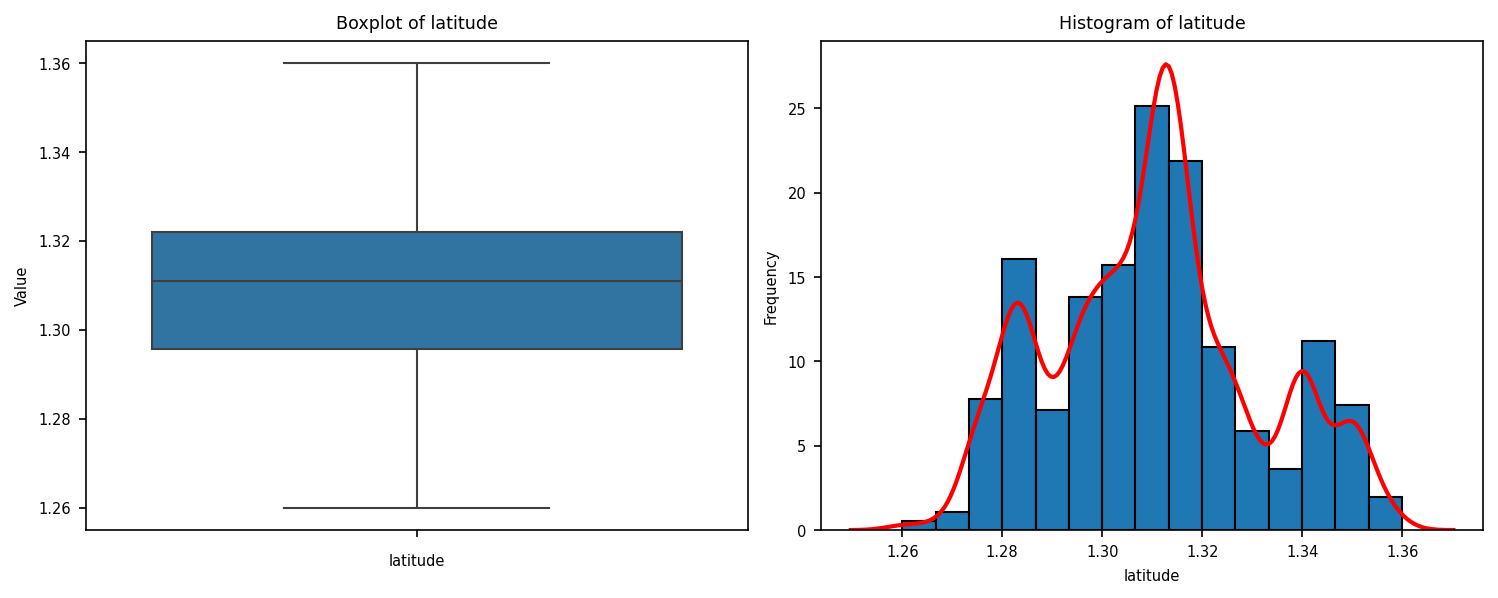

Tổng quan về outlier của cột latitude
Số lượng outlier: 0
Khoảng outlier: None
Tỷ lệ % của outlier so với tập dữ liệu: 0.0%


In [ ]:
df["latitude"] = df["latitude"].clip(lower=1.26)
df["latitude"] = df["latitude"].apply(lambda x: 1.34 if 1.36 <= x < 1.4 else
                                                        1.35 if 1.4 <= x else x)
box_hist(df, "latitude")
col_outlier, range_outlier = count_outliers_col(df, "latitude")
overview_outliers(df, col_outlier, "latitude", range_outlier)

### longitude

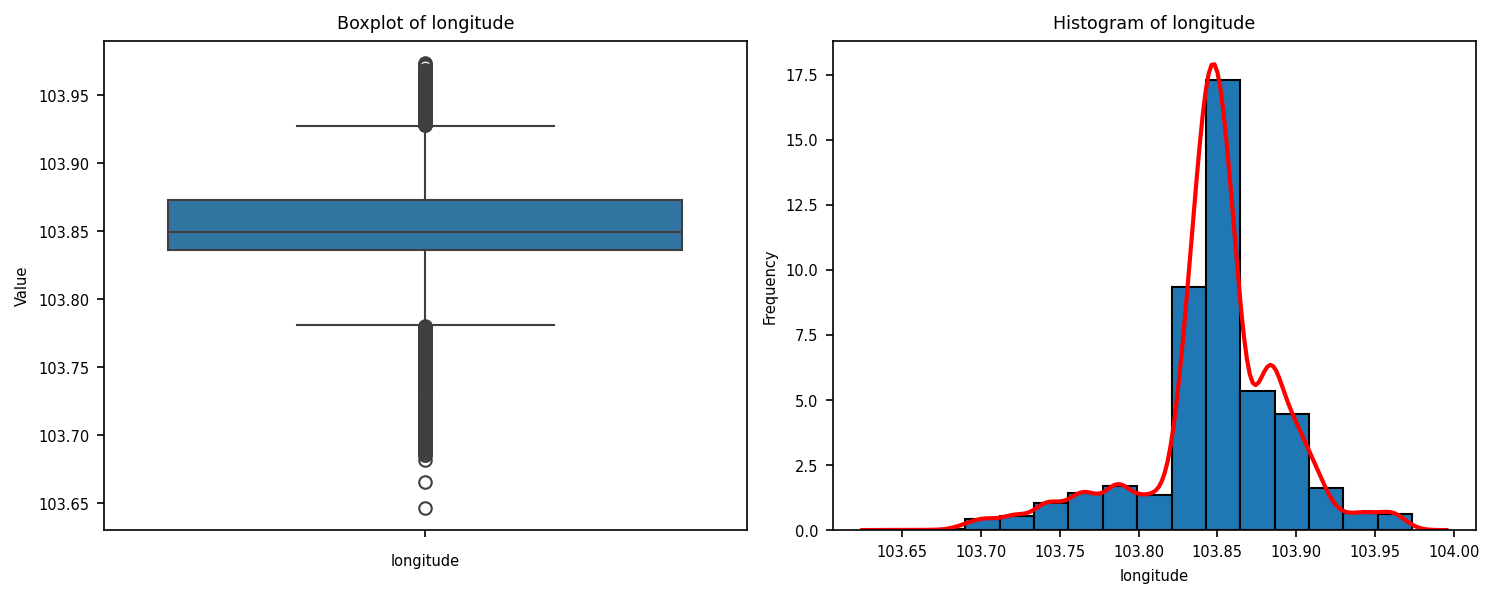

Tổng quan về outlier của cột longitude
Số lượng outlier: 839
Khoảng outlier: [103.65, 103.78) ∪ (103.93, 103.97]
Tỷ lệ % của outlier so với tập dữ liệu: 10.61%


In [ ]:
box_hist(df, "longitude")
col_outlier, range_outlier = count_outliers_col(df, "longitude")
overview_outliers(df, col_outlier, "longitude", range_outlier)

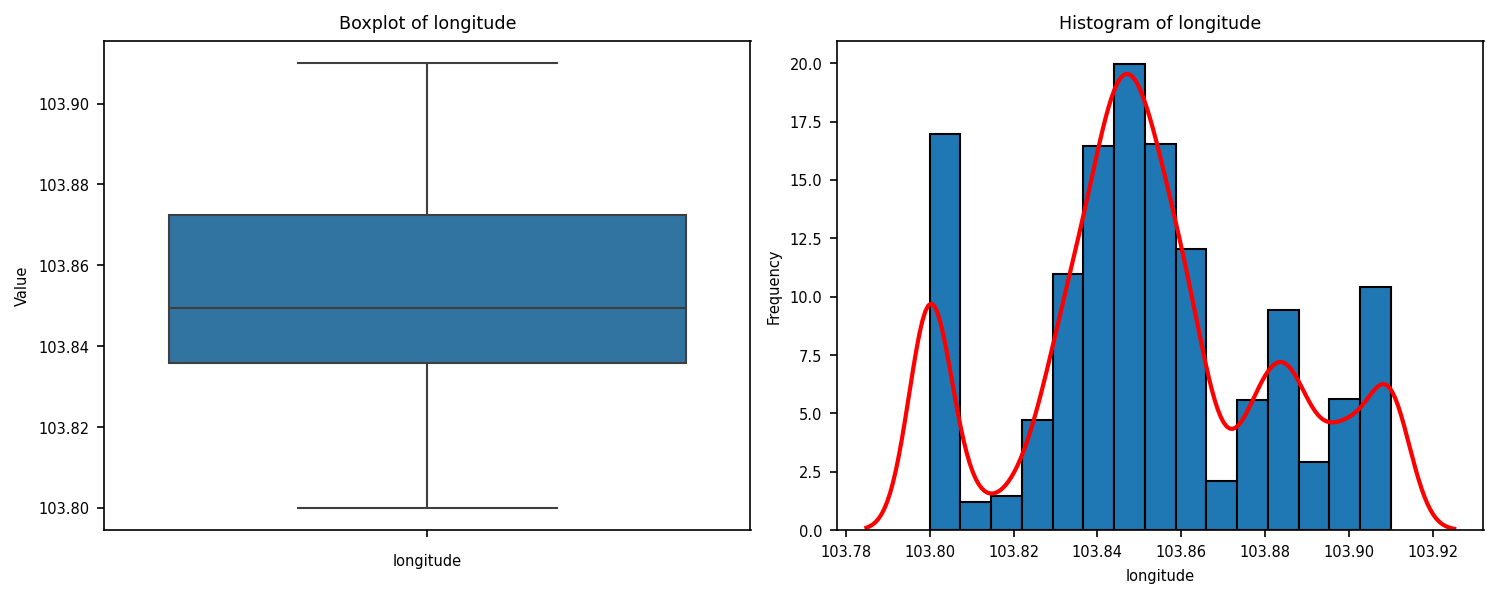

Tổng quan về outlier của cột longitude
Số lượng outlier: 0
Khoảng outlier: None
Tỷ lệ % của outlier so với tập dữ liệu: 0.0%


In [ ]:
df["longitude"] = df["longitude"].clip(lower=103.8, upper=103.91)

box_hist(df, "longitude")
col_outlier, range_outlier = count_outliers_col(df, "longitude")
overview_outliers(df, col_outlier, "longitude", range_outlier)


### minimum_nights

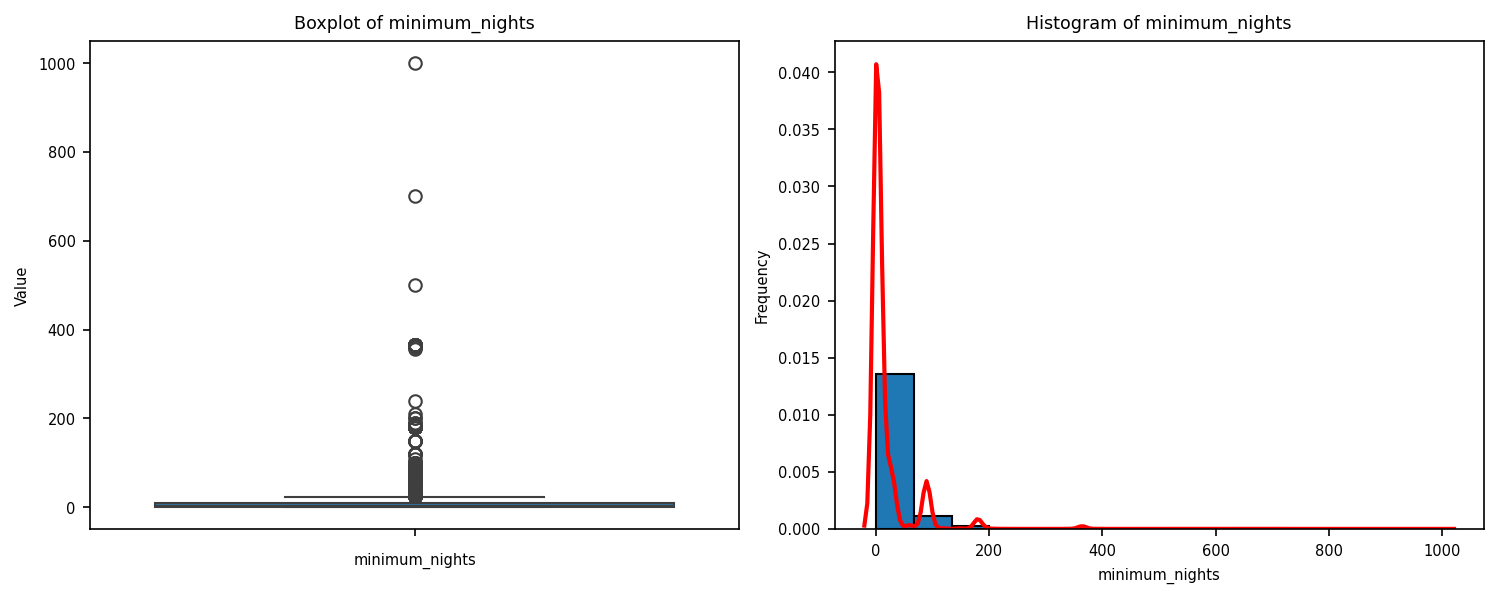

Tổng quan về outlier của cột minimum_nights
Số lượng outlier: 1407
Khoảng outlier: (23.5, 1000.0]
Tỷ lệ % của outlier so với tập dữ liệu: 17.8%


In [ ]:
box_hist(df, "minimum_nights")
col_outlier, range_outlier = count_outliers_col(df, "minimum_nights")
overview_outliers(df, col_outlier, "minimum_nights", range_outlier)

In [ ]:
get_value_frequency(df, "minimum_nights")

minimum_nights  frequency
0                1       2089
1                2       1388
2                3       1132
7                4        214
6                5        401
..             ...        ...
39             360          3
20             365         30
71             500          1
57             700          1
65            1000          1

[73 rows x 2 columns]

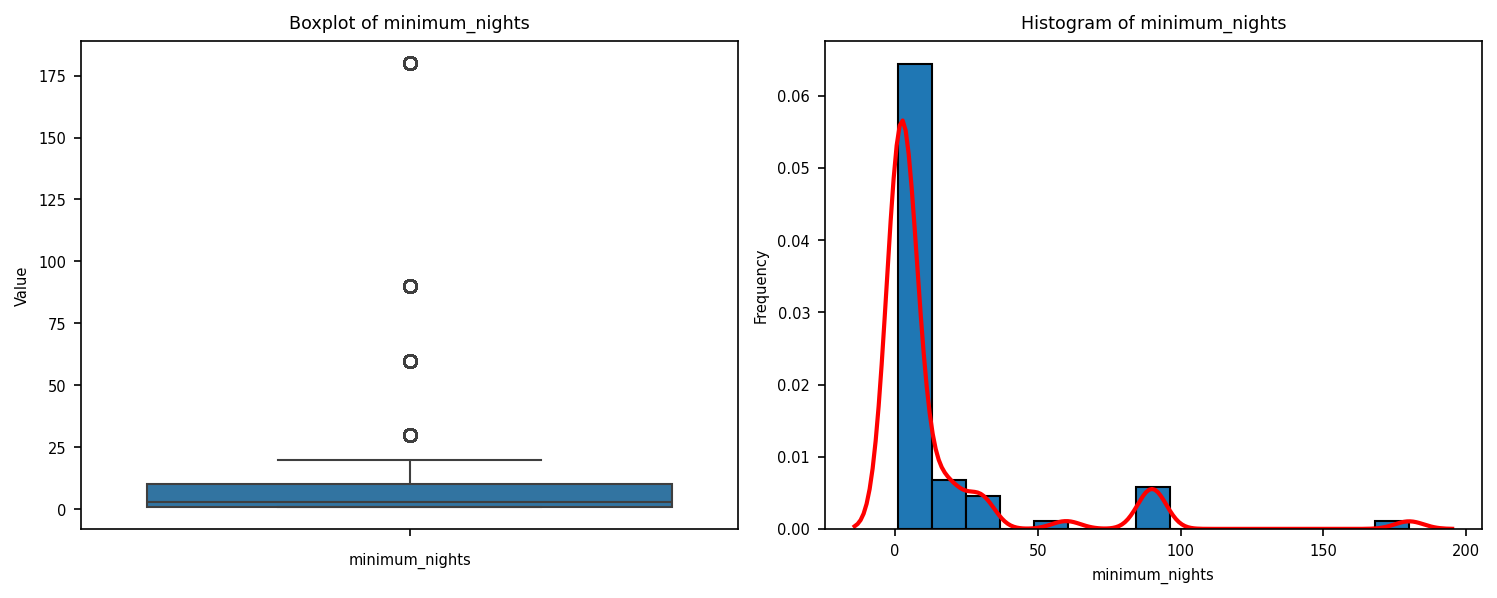

Tổng quan về outlier của cột minimum_nights
Số lượng outlier: 1184
Khoảng outlier: (23.5, 180.0]
Tỷ lệ % của outlier so với tập dữ liệu: 15.09%


In [ ]:
df = df.drop(df[df["minimum_nights"] > 180].index).reset_index(drop=True)

df["minimum_nights"] = df["minimum_nights"].apply(lambda x: 20 if 20 <= x < 30 else
                                                              30 if 30 <= x < 60 else
                                                              60 if 60 <= x < 90 else
                                                              90 if 90 <= x < 180 else x)
box_hist(df, "minimum_nights")
col_outlier, range_outlier = count_outliers_col(df, "minimum_nights")
overview_outliers(df, col_outlier, "minimum_nights", range_outlier)

### number_of_reviews

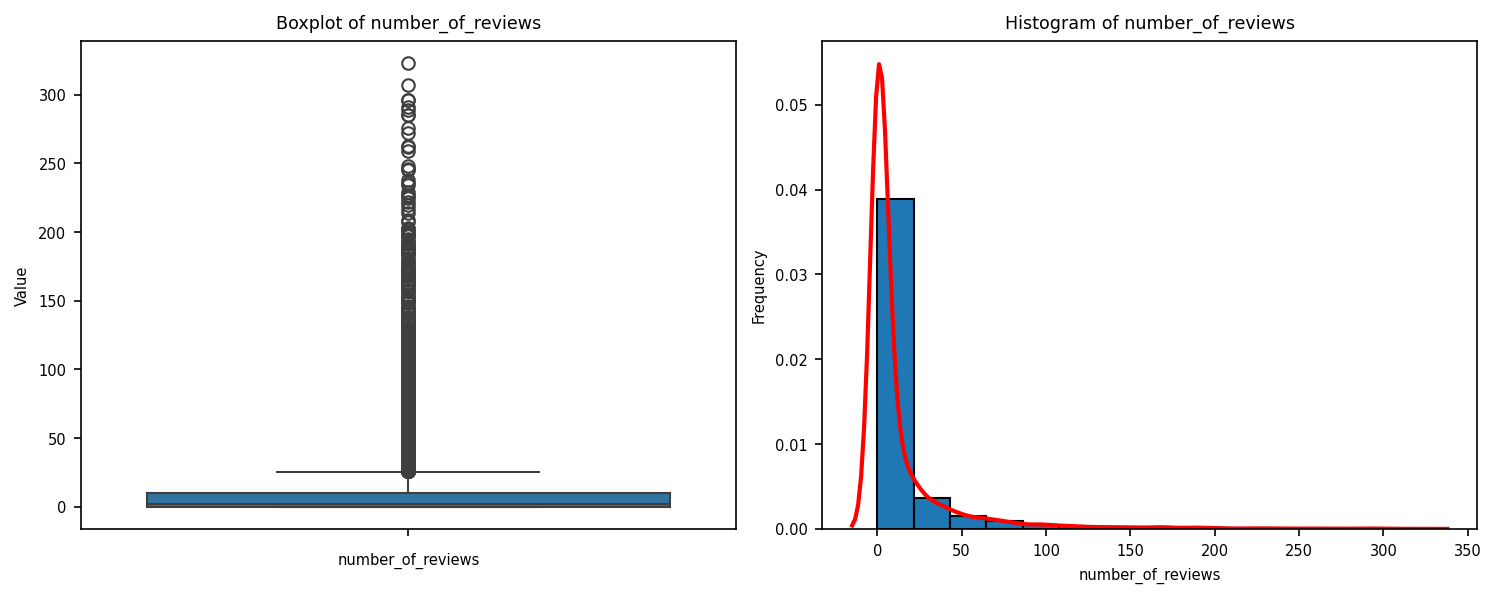

Tổng quan về outlier của cột number_of_reviews
Số lượng outlier: 1099
Khoảng outlier: (25.0, 323.0]
Tỷ lệ % của outlier so với tập dữ liệu: 14.01%


In [ ]:
box_hist(df, "number_of_reviews")
col_outlier, range_outlier = count_outliers_col(df, "number_of_reviews")
overview_outliers(df, col_outlier, "number_of_reviews", range_outlier)

In [ ]:
get_value_frequency(df, "number_of_reviews")

number_of_reviews  frequency
0                    0       2711
1                    1       1083
2                    2        588
3                    3        373
4                    4        256
..                 ...        ...
179                289          1
198                291          1
144                296          2
194                307          1
197                323          1

[208 rows x 2 columns]

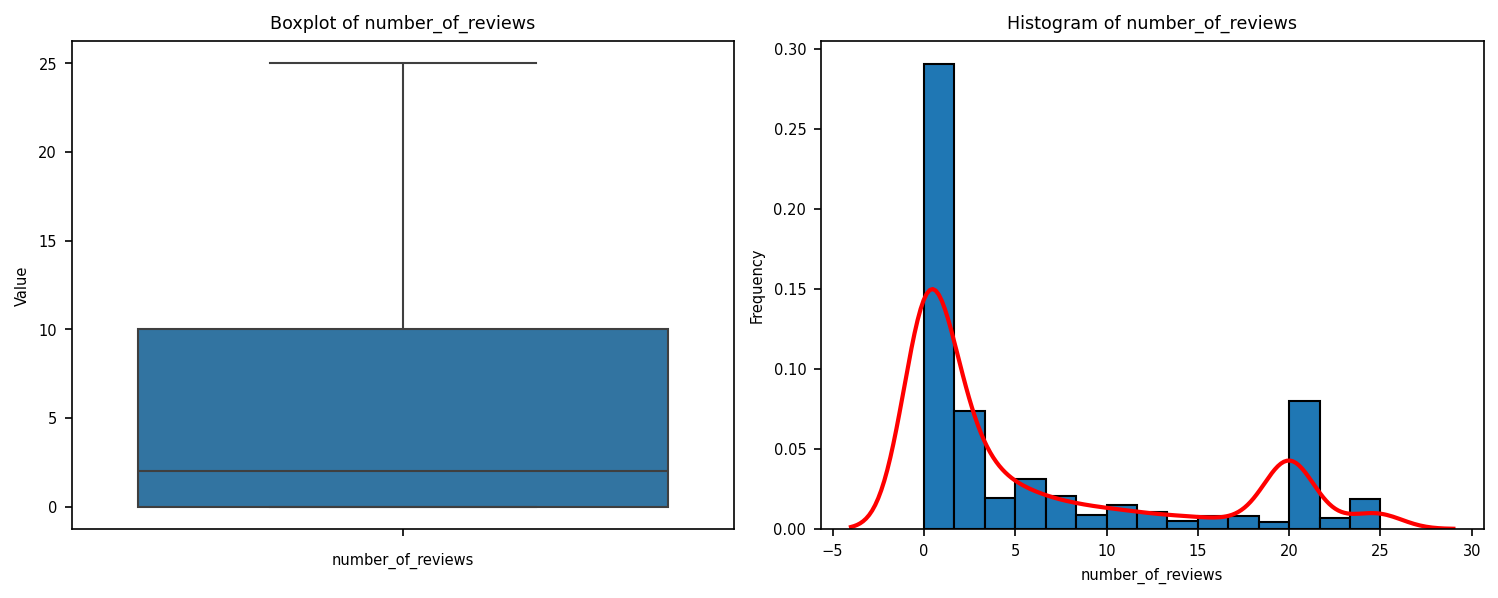

Tổng quan về outlier của cột number_of_reviews
Số lượng outlier: 0
Khoảng outlier: None
Tỷ lệ % của outlier so với tập dữ liệu: 0.0%


In [ ]:
df["number_of_reviews"] = df["number_of_reviews"].apply(lambda x: 20 if 25 <= x < 100 else
                                                        25 if 100 <= x else x)
box_hist(df, "number_of_reviews")
col_outlier, range_outlier = count_outliers_col(df, "number_of_reviews")
overview_outliers(df, col_outlier, "number_of_reviews", range_outlier)

### calculated_host_listings_count

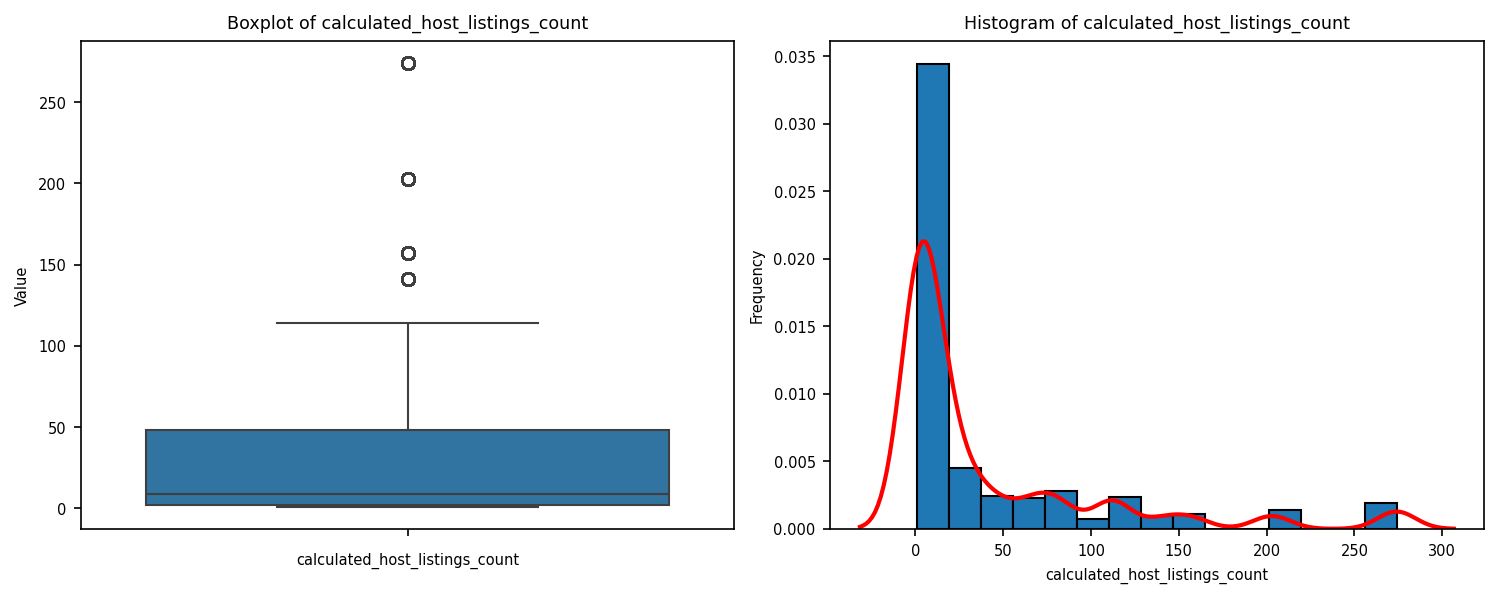

Tổng quan về outlier của cột calculated_host_listings_count
Số lượng outlier: 775
Khoảng outlier: (117.0, 274.0]
Tỷ lệ % của outlier so với tập dữ liệu: 9.88%


In [ ]:
box_hist(df, "calculated_host_listings_count")
col_outlier, range_outlier = count_outliers_col(df, "calculated_host_listings_count")
overview_outliers(df, col_outlier, "calculated_host_listings_count", range_outlier)

In [ ]:
get_value_frequency(df, "calculated_host_listings_count")

calculated_host_listings_count  frequency
0                                1       1914
1                                2        641
2                                3        338
4                                4        216
10                               5        174
8                                6        187
7                                7        189
9                                8        184
14                               9        135
16                              10        120
25                              11         88
39                              12         60
15                              13        130
12                              14        154
21                              15        105
28                              16         80
34                              17         68
23                              18         90
46                              19         38
54                              20         20
53                              21         21
35                              22         66
52                              23         23
33                              24         72
51                              25         25
30                              26         78
42                              27         54
41                              28         56
38                              30         60
37                              31         61
50                              32         32
49                              34         34
48                              37         37
47                              38         38
45                              40         40
44                              41         41
43                              43         42
24                              45         90
22                              48         96
40                              59         59
36                              64         64
6                               67        201
32                              76         76
31                              78         78
29                              79         79
27                              83         83
26                              84         84
20                             109        109
19                             112        112
18                             113        113
17                             114        114
13                             141        141
11                             157        157
5                              203        203
3                              274        274

### price

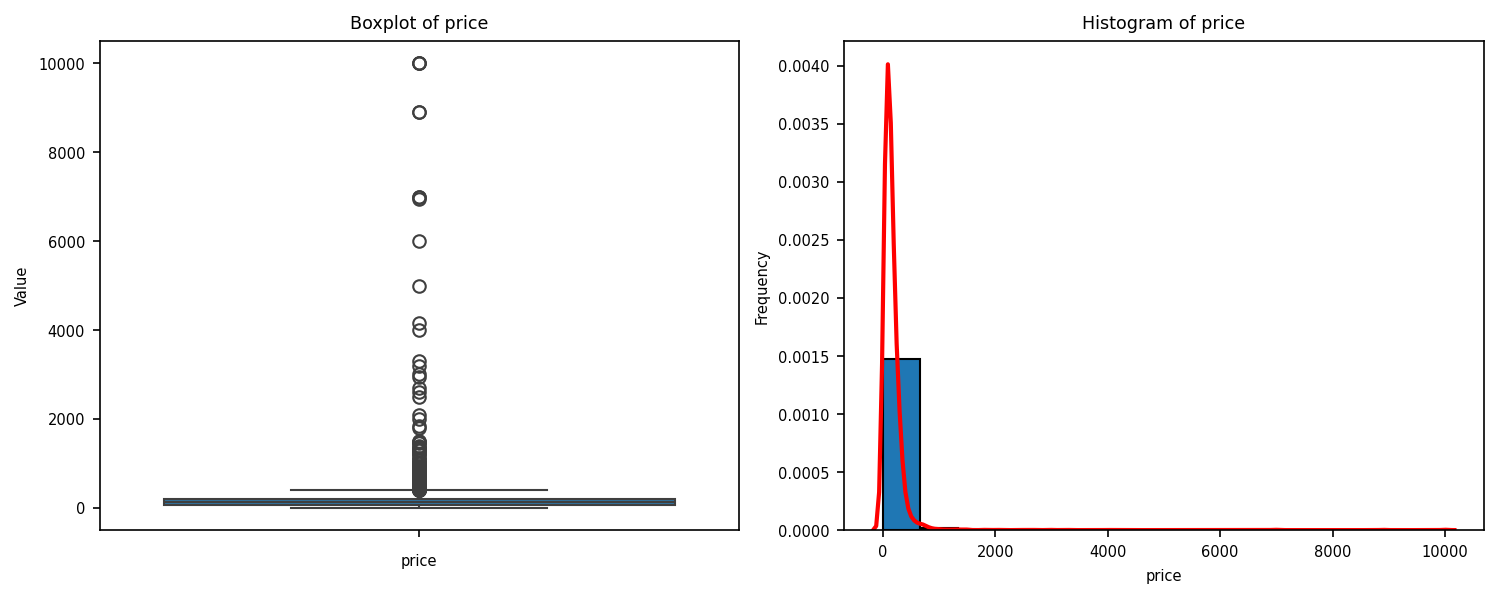

Tổng quan về outlier của cột price
Số lượng outlier: 319
Khoảng outlier: (400.0, 10000.0]
Tỷ lệ % của outlier so với tập dữ liệu: 4.07%
Total Outliers > 600: 129 accounting for 40.44%


In [ ]:
box_hist(df, "price")
col_outlier, range_outlier = count_outliers_col(df, "price")
overview_outliers(df, col_outlier, "price", range_outlier)

value = 600
count = (col_outlier["price"] > value).sum()
per = count / len(col_outlier)
print(f"Total Outliers > {value}: {count} accounting for {round(per * 100, 2)}%")

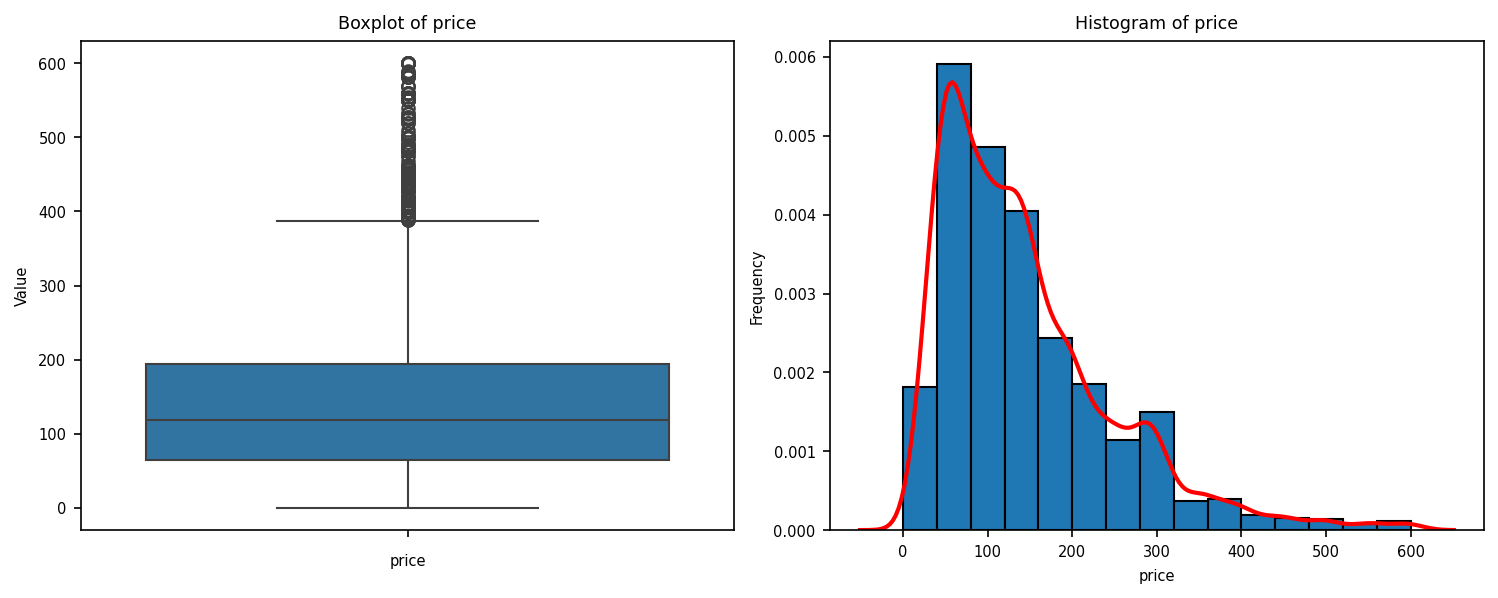

Tổng quan về outlier của cột price
Số lượng outlier: 236
Khoảng outlier: (387.5, 600.0]
Tỷ lệ % của outlier so với tập dữ liệu: 3.06%


In [ ]:
df = df.drop(df[df["price"] > 600].index).reset_index(drop=True)

box_hist(df, "price")
col_outlier, range_outlier = count_outliers_col(df, "price")
overview_outliers(df, col_outlier, "price", range_outlier)

In [ ]:
get_value_frequency(df, "price")

price  frequency
281      0          1
198     14          4
191     15          5
199     18          4
81      19         28
..     ...        ...
195    581          4
193    587          4
282    590          1
257    599          1
115    600         17

[299 rows x 2 columns]

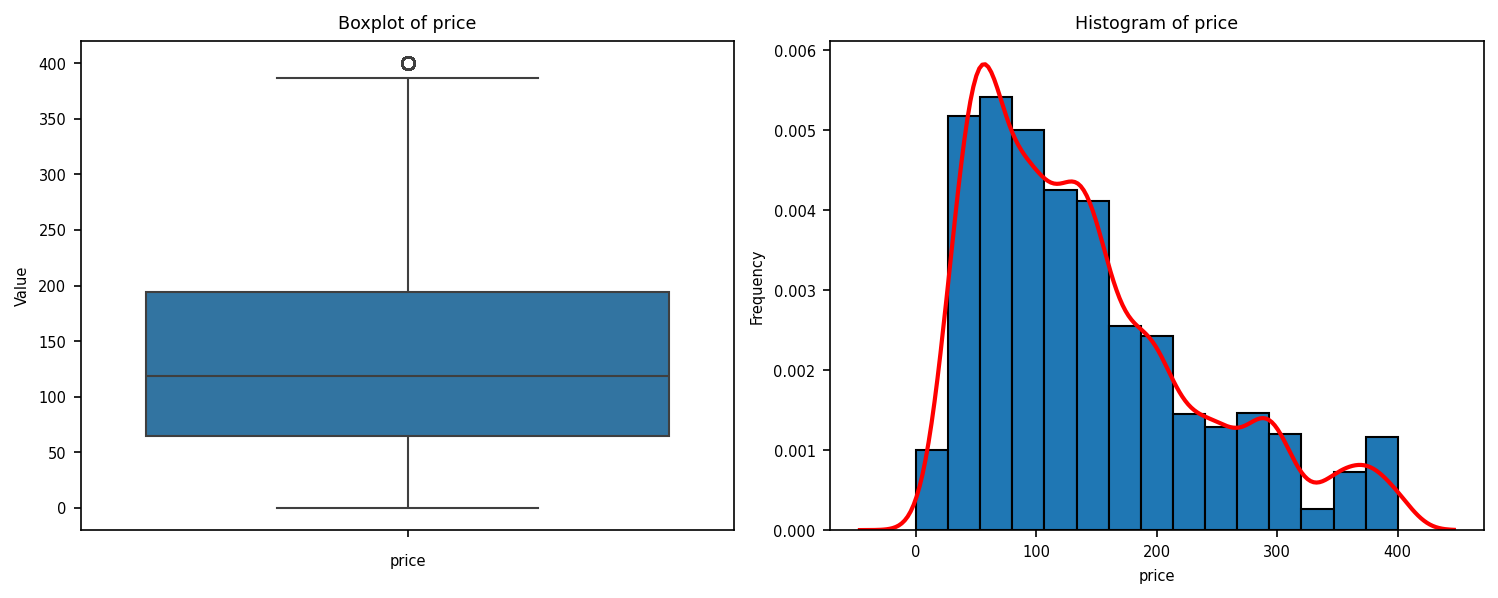

Tổng quan về outlier của cột price
Số lượng outlier: 85
Khoảng outlier: (387.5, 400.0]
Tỷ lệ % của outlier so với tập dữ liệu: 1.1%


In [ ]:
df["price"] = df["price"].apply(lambda x: 350 if 387.5 < x <= 400 else
                                                              375 if 400 <= x < 500 else
                                                              400 if 500 <= x else x)
box_hist(df, "price")
col_outlier, range_outlier = count_outliers_col(df, "price")
overview_outliers(df, col_outlier, "price", range_outlier)

In [ ]:
df

neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
0                       2              9   1.35000  103.80000          2   
1                       4             16   1.33235  103.80000          2   
2                       2              9   1.35000  103.80000          2   
3                       3             11   1.34541  103.91000          2   
4                       3             11   1.34567  103.91000          2   
...                   ...            ...       ...        ...        ...   
7710                    4             15   1.27973  103.80000          3   
7711                    4             21   1.29269  103.82623          3   
7712                    4             17   1.31286  103.85996          2   
7713                    4             17   1.29543  103.83801          2   
7714                    4             17   1.29672  103.83325          2   

      minimum_nights  number_of_reviews  calculated_host_listings_count  \
0                180                  1                               2   
1                 90                 18                               1   
2                  6                 20                               2   
3                  1                 14                               9   
4                  1                 22                               9   
...              ...                ...                             ...   
7710               3                  0                              31   
7711               6                  0                              34   
7712              30                  0                               3   
7713              14                  0                               2   
7714              90                  0                               7   

      availability_365  price  
0                  365     83  
1                  365     81  
2                  365     69  
3                  353    206  
4                  355     94  
...                ...    ...  
7710                61    100  
7711               365    400  
7712               173     58  
7713                30     56  
7714               365     65  

[7715 rows x 10 columns]

## Decision tree

In [ ]:
independent = df.columns[df.columns != "price"].tolist()
dependent = "price"

df_results, saved_models, feature_importance_df = decisiontree_model(df, independent, dependent, max_depth=5, min_samples_split=3, n_splits=5) # Các chỉ số max_depth, min_samples_split ngẫu nhiên
save_model("DecisionTree", "DT-NoOL-Random", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE
Fold                                                             
1         48.7    47.67      66.67     65.21      46.44     43.65
2        48.22    49.36      65.96     67.42       46.2      42.4
3        47.97    51.74      65.79     70.16      41.87     61.25
4        47.61    52.16      65.45     71.27      45.12     44.78
5        47.93    48.64      65.87     68.38      45.26     42.37
Mean     48.09    49.91      65.95     68.49      44.98     46.89

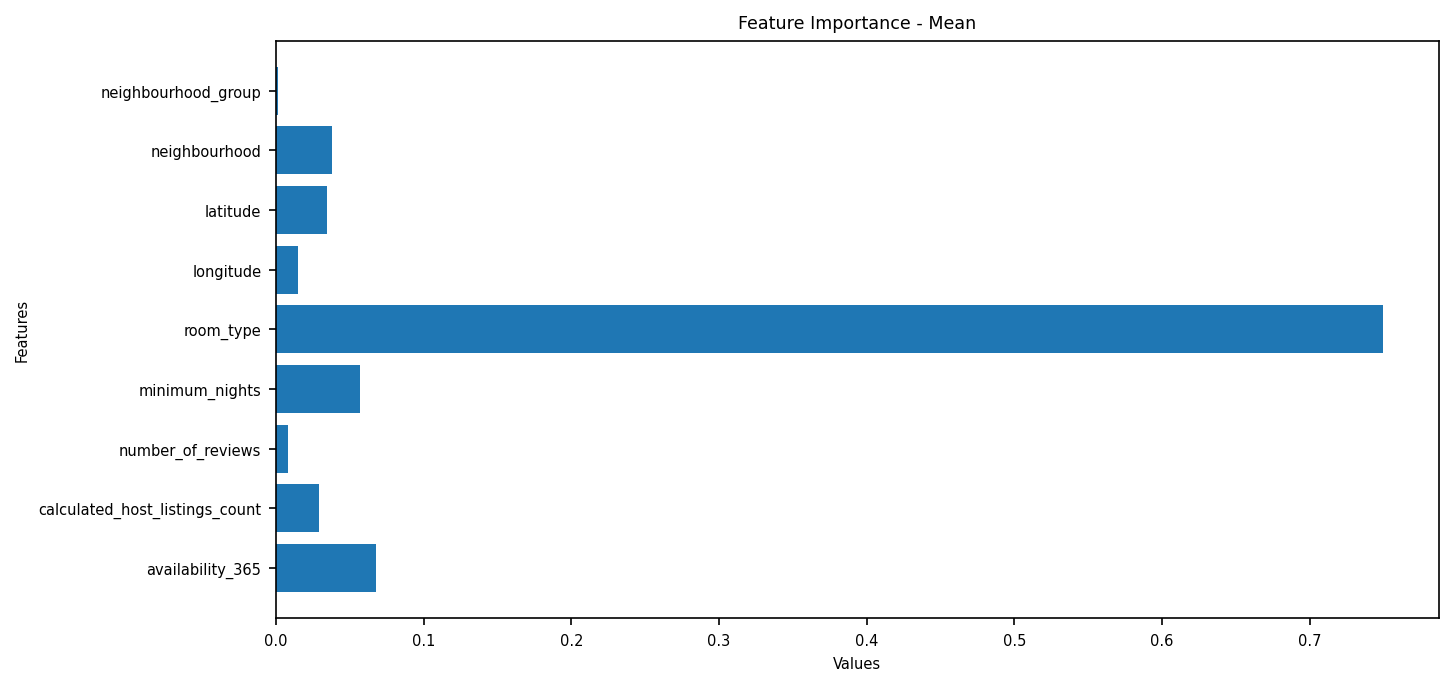

neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
Fold 1               0.0000         0.0305    0.0383     0.0246     0.7369   
Fold 2               0.0000         0.0366    0.0288     0.0096     0.7436   
Fold 3               0.0048         0.0380    0.0284     0.0158     0.7627   
Fold 4               0.0033         0.0368    0.0280     0.0159     0.7566   
Fold 5               0.0000         0.0475    0.0492     0.0069     0.7496   
Mean                 0.0016         0.0379    0.0345     0.0146     0.7499   

        minimum_nights  number_of_reviews  calculated_host_listings_count  \
Fold 1          0.0652             0.0104                          0.0293   
Fold 2          0.0544             0.0120                          0.0299   
Fold 3          0.0511             0.0038                          0.0179   
Fold 4          0.0528             0.0142                          0.0433   
Fold 5          0.0611             0.0000                          0.0244   
Mean            0.0569             0.0081                          0.0290   

        availability_365  
Fold 1            0.0648  
Fold 2            0.0850  
Fold 3            0.0775  
Fold 4            0.0492  
Fold 5            0.0613  
Mean              0.0676

In [ ]:
plot_feature_importance(feature_importance_df, row_index=5)
feature_importance_df

## Random Forest

In [ ]:
independent = df.columns[df.columns != "price"].tolist()
dependent = "price"

df_results, saved_models, feature_importance_df = randomforest_model(df, independent, dependent, n_estimators=2, max_depth=5, min_samples_split=3, n_splits=5) # Các chỉ số n_estimators, max_depth, min_samples_split ngẫu nhiên
save_model("RandomForest", "RF-NoOL-Random", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE
Fold                                                             
1        48.11    47.41      65.38     64.27      45.94     44.11
2        47.98    48.81      65.57     66.83      45.72     41.82
3        47.64    51.73      65.06     70.41      41.63     61.34
4        47.34    51.43      64.98      70.1      44.31     43.78
5        47.47     48.9      65.01     68.09      44.52     42.83
Mean     47.71    49.66       65.2     67.94      44.42     46.78

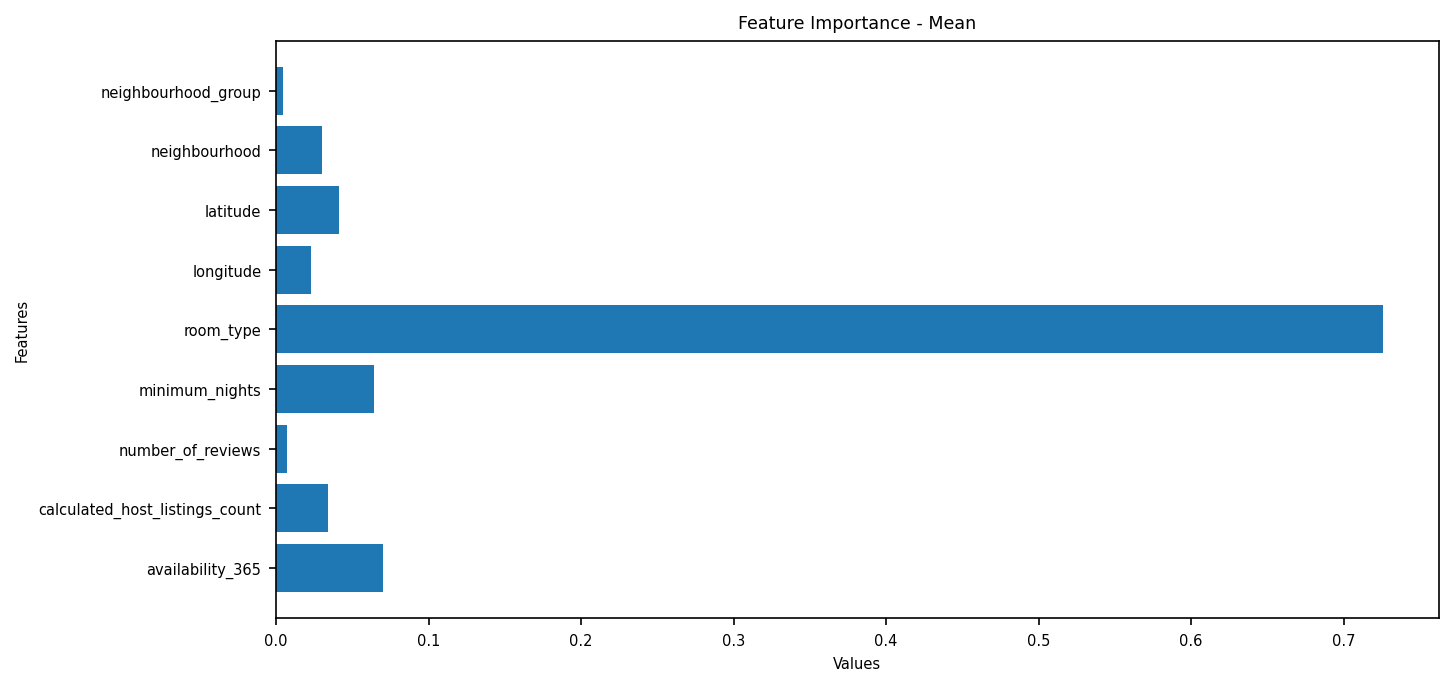

neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
Fold 1               0.0000         0.0086    0.0422     0.0344     0.7153   
Fold 2               0.0053         0.0282    0.0538     0.0173     0.7210   
Fold 3               0.0158         0.0190    0.0376     0.0168     0.7328   
Fold 4               0.0021         0.0433    0.0230     0.0226     0.7331   
Fold 5               0.0000         0.0516    0.0498     0.0239     0.7273   
Mean                 0.0046         0.0301    0.0413     0.0230     0.7259   

        minimum_nights  number_of_reviews  calculated_host_listings_count  \
Fold 1          0.0565             0.0054                          0.0683   
Fold 2          0.0630             0.0061                          0.0188   
Fold 3          0.0720             0.0033                          0.0125   
Fold 4          0.0624             0.0161                          0.0471   
Fold 5          0.0664             0.0039                          0.0245   
Mean            0.0641             0.0070                          0.0342   

        availability_365  
Fold 1            0.0693  
Fold 2            0.0866  
Fold 3            0.0903  
Fold 4            0.0503  
Fold 5            0.0527  
Mean              0.0698

In [ ]:
plot_feature_importance(feature_importance_df, row_index=5)
feature_importance_df

# Tối ưu mô hình

## Decision Tree

In [ ]:
X = df[['neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights', "number_of_reviews", "availability_365" ]]
y = df['price']

cv = KFold(n_splits=5, shuffle=True, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Định nghĩa không gian tham số cho Random Search với giá trị hợp lệ
param_dist = {
'max_depth': randint(1, 21), # Độ sâu tối đa của cây
'min_samples_split': randint(2, 21), # Số mẫu tối thiểu để chia một nút
'min_samples_leaf': randint(1, 20), # Số mẫu tối thiểu trong một nút lá
}

# Khởi tạo RandomizedSearchCV
random_search = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions=param_dist, n_iter=100, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv, random_state=1)

random_result = random_search.fit(X, y)

# In kết quả của Random Search
print('Giá trị MSE tốt nhất tìm được: %s' % random_result.best_score_)
print('Tham số tương ứng: %s' % random_result.best_params_)

Giá trị MSE tốt nhất tìm được: -4128.062436877164
Tham số tương ứng: {'max_depth': 11, 'min_samples_leaf': 9, 'min_samples_split': 9}


In [ ]:
independent = df.columns[~df.columns.isin(["price"])].tolist()
dependent = "price"

df_results, saved_models, feature_importance_df = decisiontree_model(df, independent, dependent, max_depth=11, min_samples_split=9, min_samples_leaf=9, n_splits=5)
save_model("DecisionTree", "DT-NoOL-Randomized", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE
Fold                                                             
1        35.52    41.81      51.74     61.91      32.68     37.38
2        34.32    44.03      50.78     63.37      32.78     38.07
3        34.86    45.46      51.52     65.58      29.97     48.37
4        34.54    44.21      50.36     65.51      32.45     36.58
5        36.04    44.25      52.46     65.24      34.12     36.93
Mean     35.06    43.95      51.37     64.32       32.4     39.47

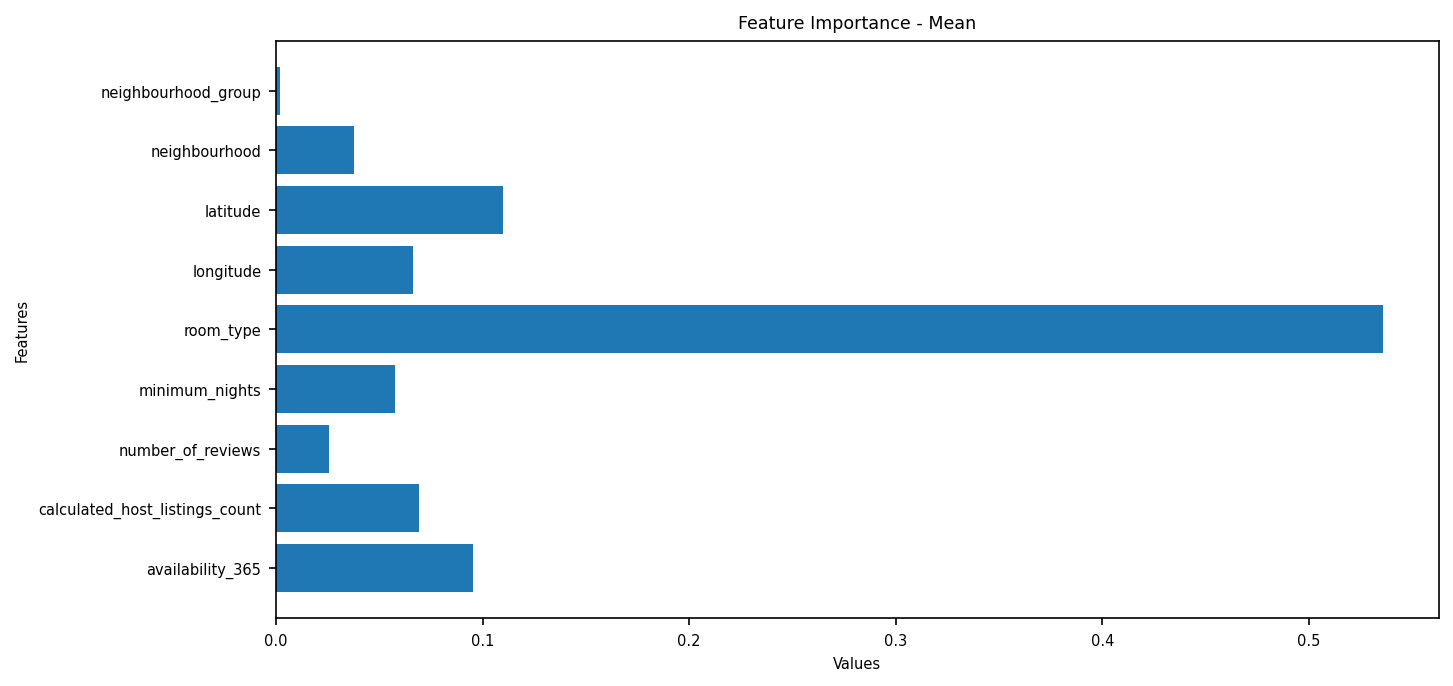

neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
Fold 1               0.0000         0.0363    0.1159     0.0709     0.5229   
Fold 2               0.0001         0.0354    0.1120     0.0750     0.5267   
Fold 3               0.0041         0.0361    0.1020     0.0554     0.5460   
Fold 4               0.0047         0.0387    0.0983     0.0793     0.5355   
Fold 5               0.0002         0.0425    0.1219     0.0520     0.5491   
Mean                 0.0018         0.0378    0.1100     0.0665     0.5360   

        minimum_nights  number_of_reviews  calculated_host_listings_count  \
Fold 1          0.0664             0.0205                          0.0713   
Fold 2          0.0583             0.0305                          0.0718   
Fold 3          0.0554             0.0287                          0.0643   
Fold 4          0.0542             0.0207                          0.0806   
Fold 5          0.0533             0.0287                          0.0580   
Mean            0.0575             0.0258                          0.0692   

        availability_365  
Fold 1            0.0957  
Fold 2            0.0901  
Fold 3            0.1079  
Fold 4            0.0879  
Fold 5            0.0942  
Mean              0.0952

In [ ]:
plot_feature_importance(feature_importance_df, row_index=5)
feature_importance_df

Decision Tree cho fold 4


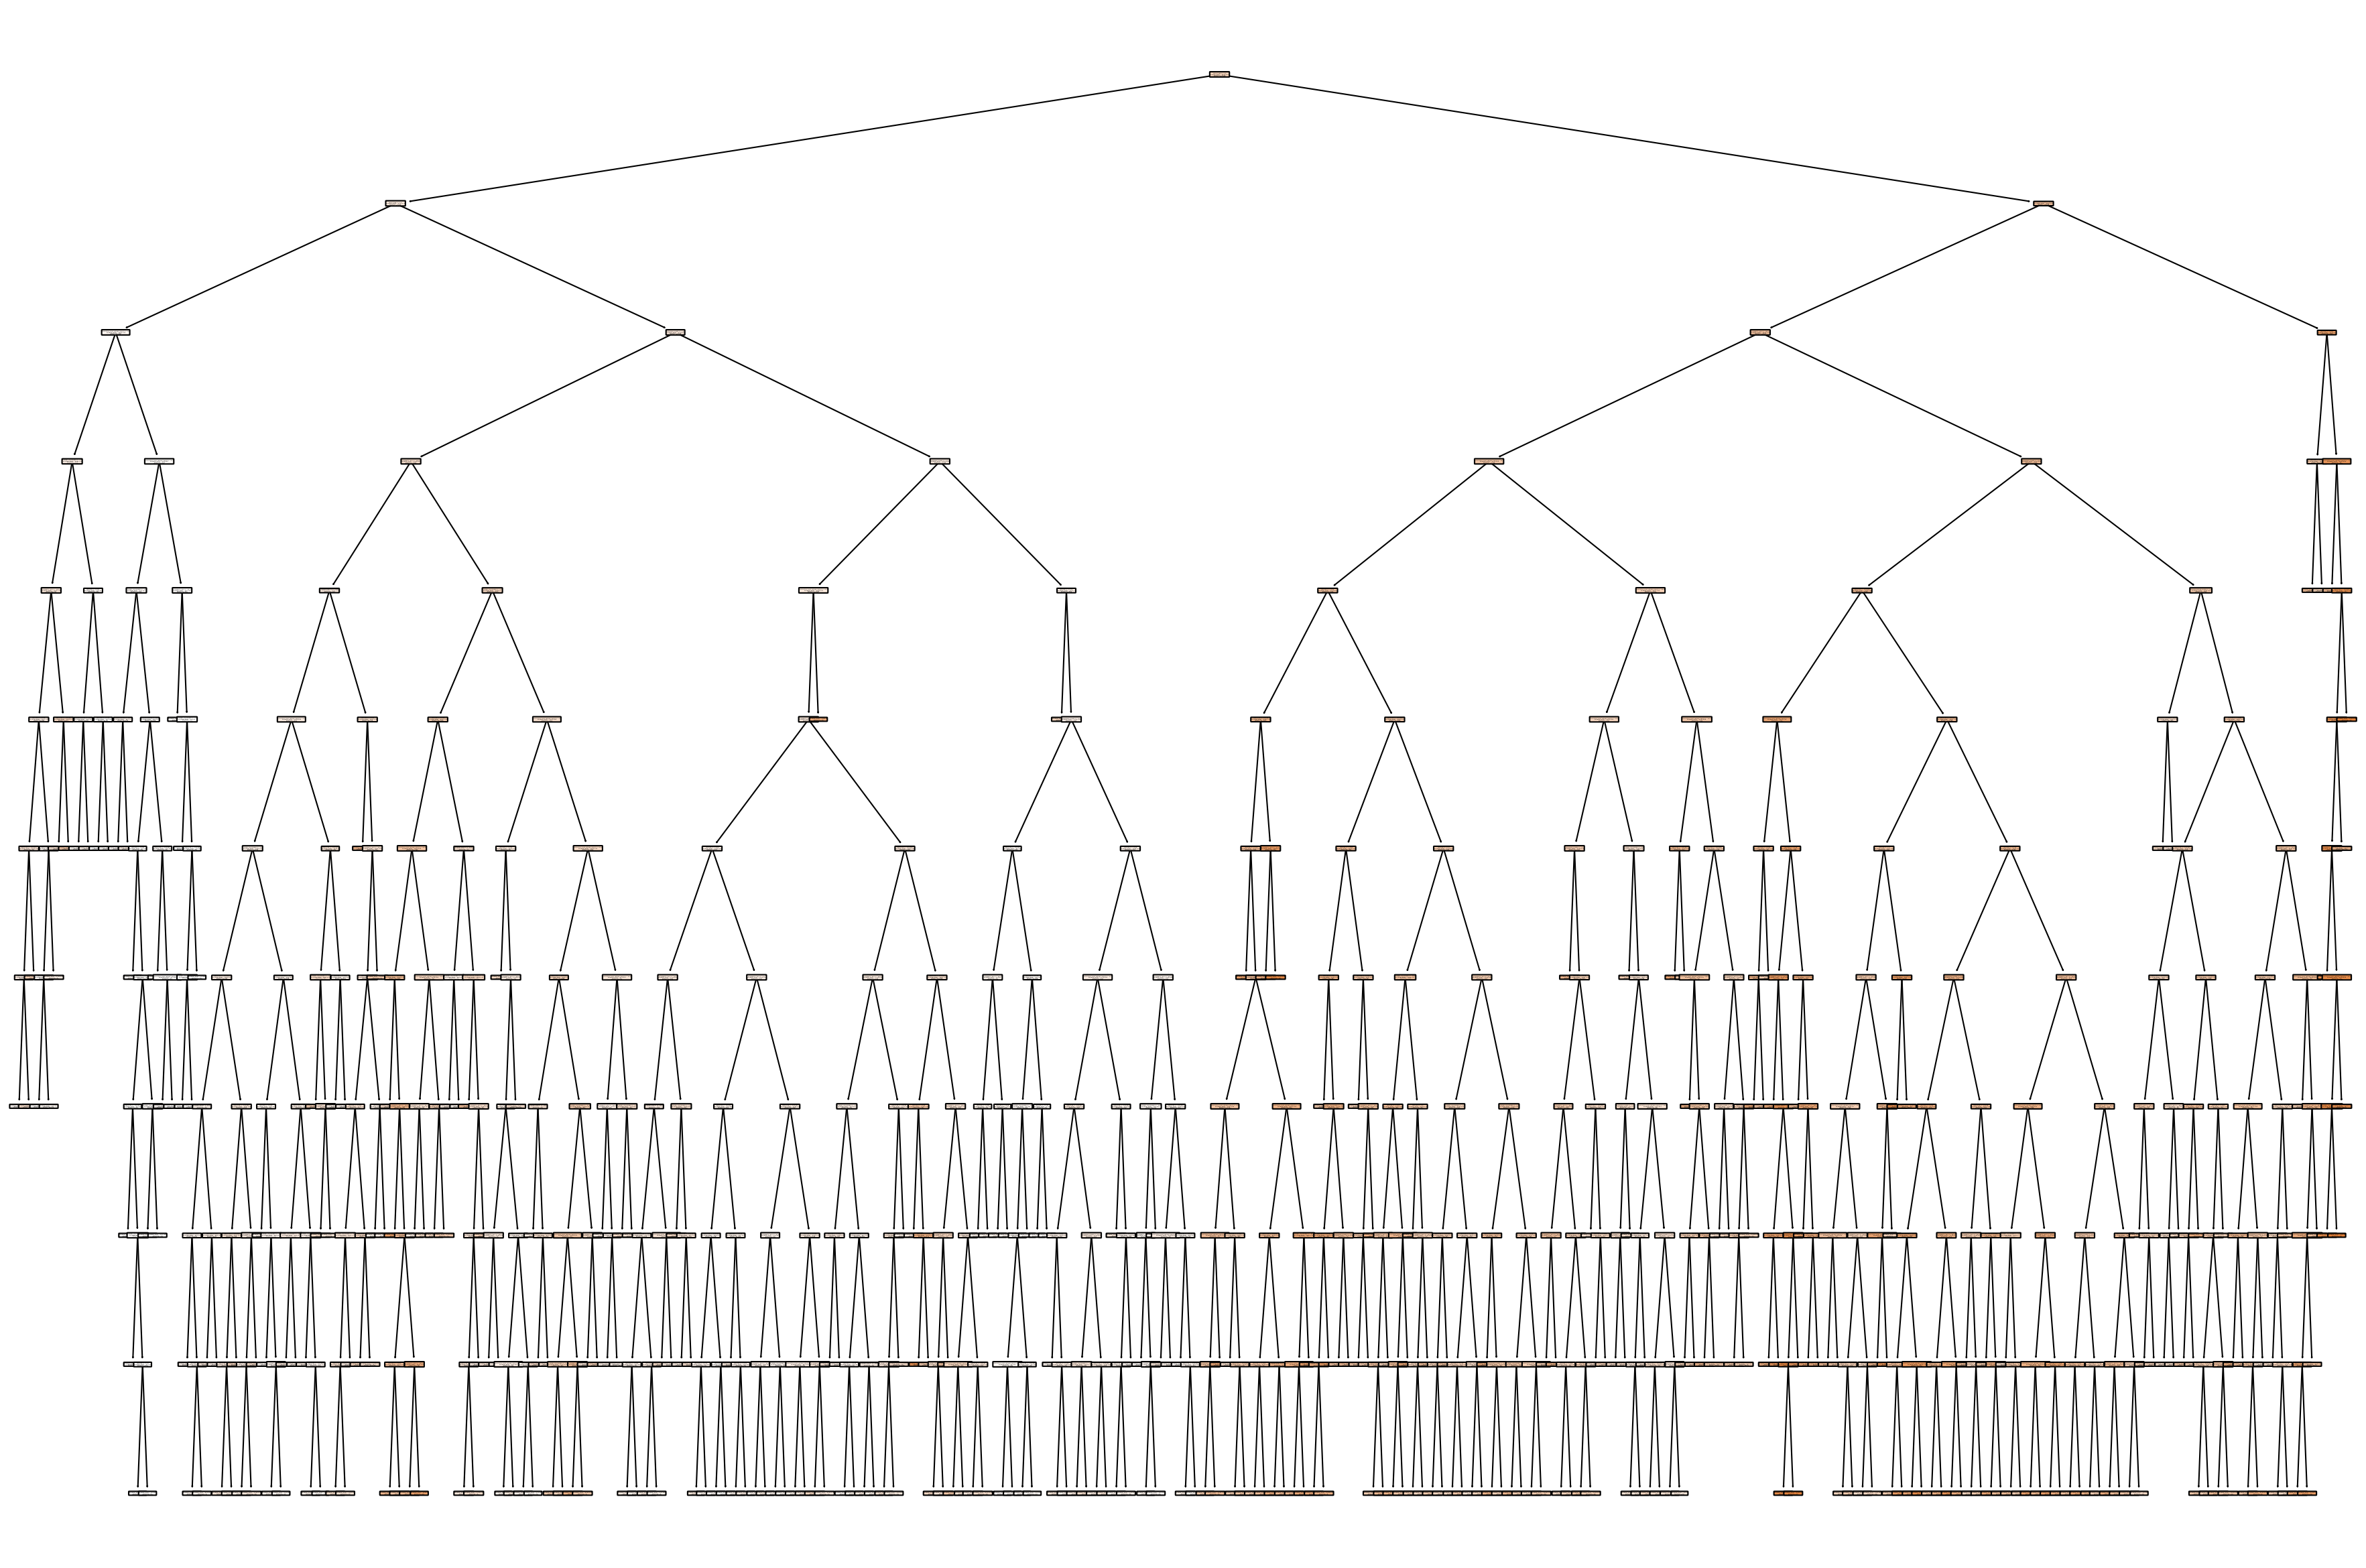

In [ ]:
from sklearn.tree import plot_tree

fold, model = saved_models[3]
print(f"Decision Tree cho fold {fold}")
plt.figure(figsize=(30, 20))
plot_tree(model, feature_names=independent, filled=True, rounded=True)
plt.show()

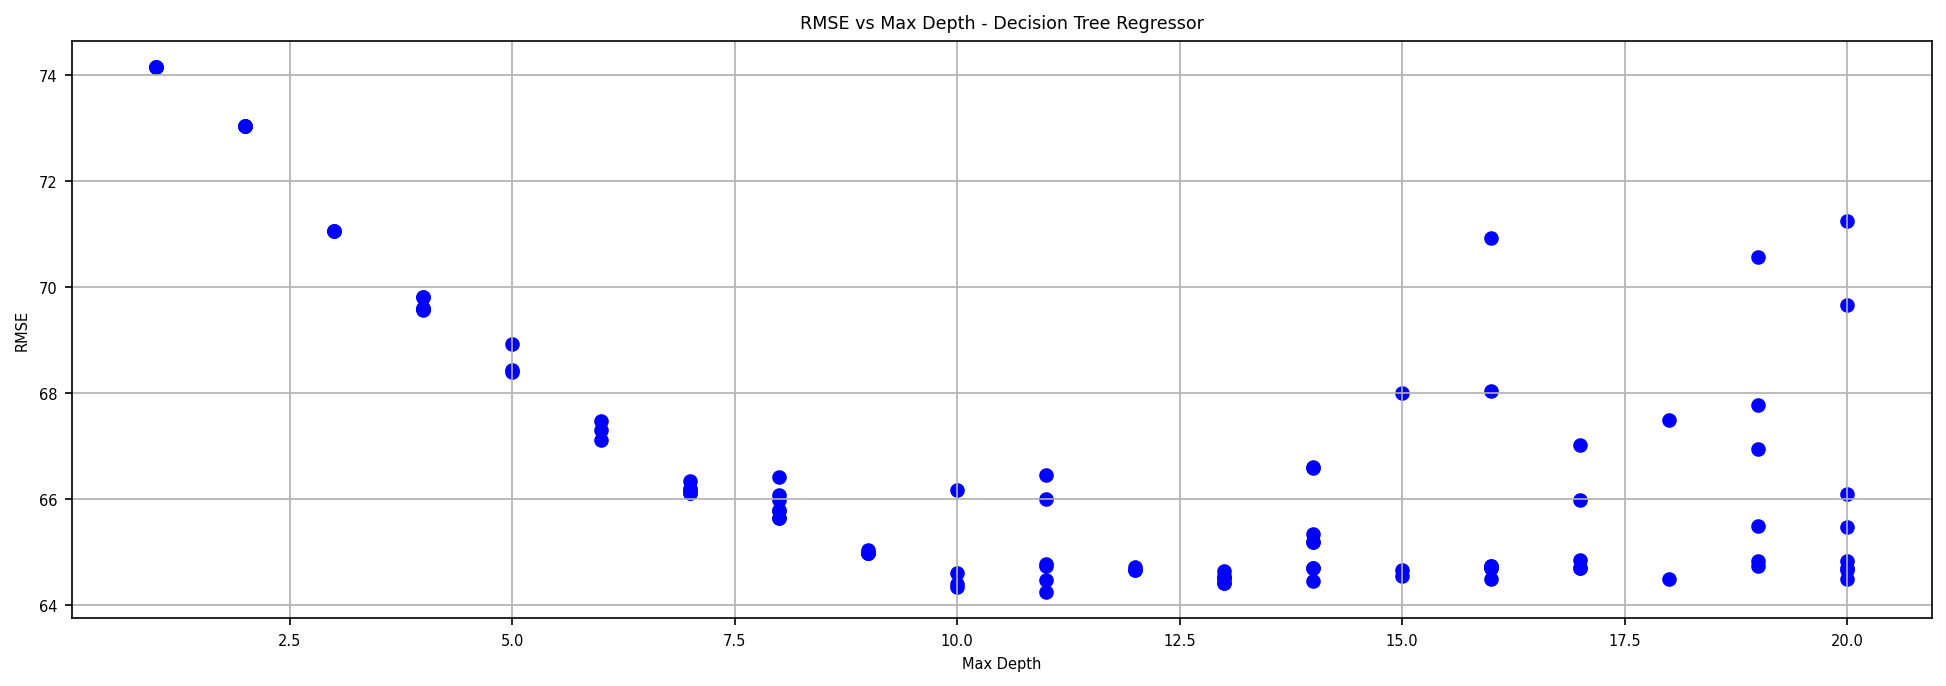

In [ ]:
results = random_search.cv_results_
# Lấy các giá trị max_depth và điểm số
param_depth = results['param_max_depth'].data
neg_mean_squared_error = results['mean_test_score']
rmse = np.sqrt(-neg_mean_squared_error)

# Tạo DataFrame để dễ dàng thao tác với dữ liệu
rmse_df = pd.DataFrame({
'max_depth': param_depth,
'RMSE': rmse
})

# Vẽ biểu đồ
plt.figure(figsize=(16, 5))
plt.scatter(rmse_df['max_depth'], rmse_df['RMSE'], marker='o', linestyle='-', color='b')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('RMSE vs Max Depth - Decision Tree Regressor')
plt.grid(True)
plt.show()

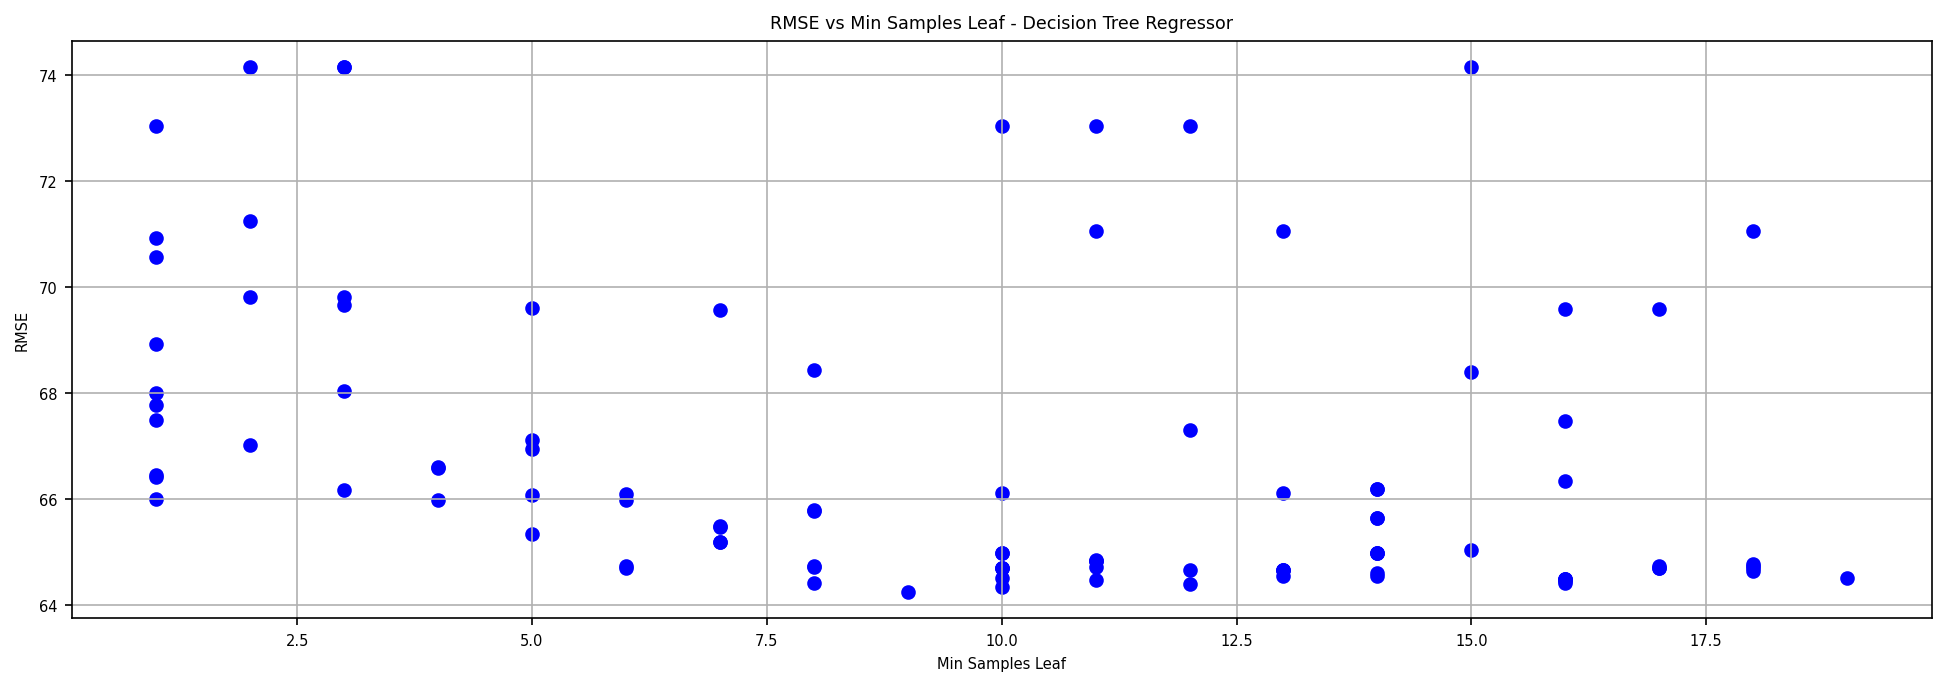

In [ ]:
# Extract values for min_samples_leaf and scores
param_min_samples_leaf = results['param_min_samples_leaf'].data
neg_mean_squared_error = results['mean_test_score']
rmse = np.sqrt(-neg_mean_squared_error)

# Create DataFrame for easy manipulation
rmse_df = pd.DataFrame({
'min_samples_leaf': param_min_samples_leaf,
'RMSE': rmse
})

# Plotting
plt.figure(figsize=(16, 5))
plt.scatter(rmse_df['min_samples_leaf'], rmse_df['RMSE'], marker='o', color='b')
plt.xlabel('Min Samples Leaf')
plt.ylabel('RMSE')
plt.title('RMSE vs Min Samples Leaf - Decision Tree Regressor')
plt.grid(True)
plt.show()

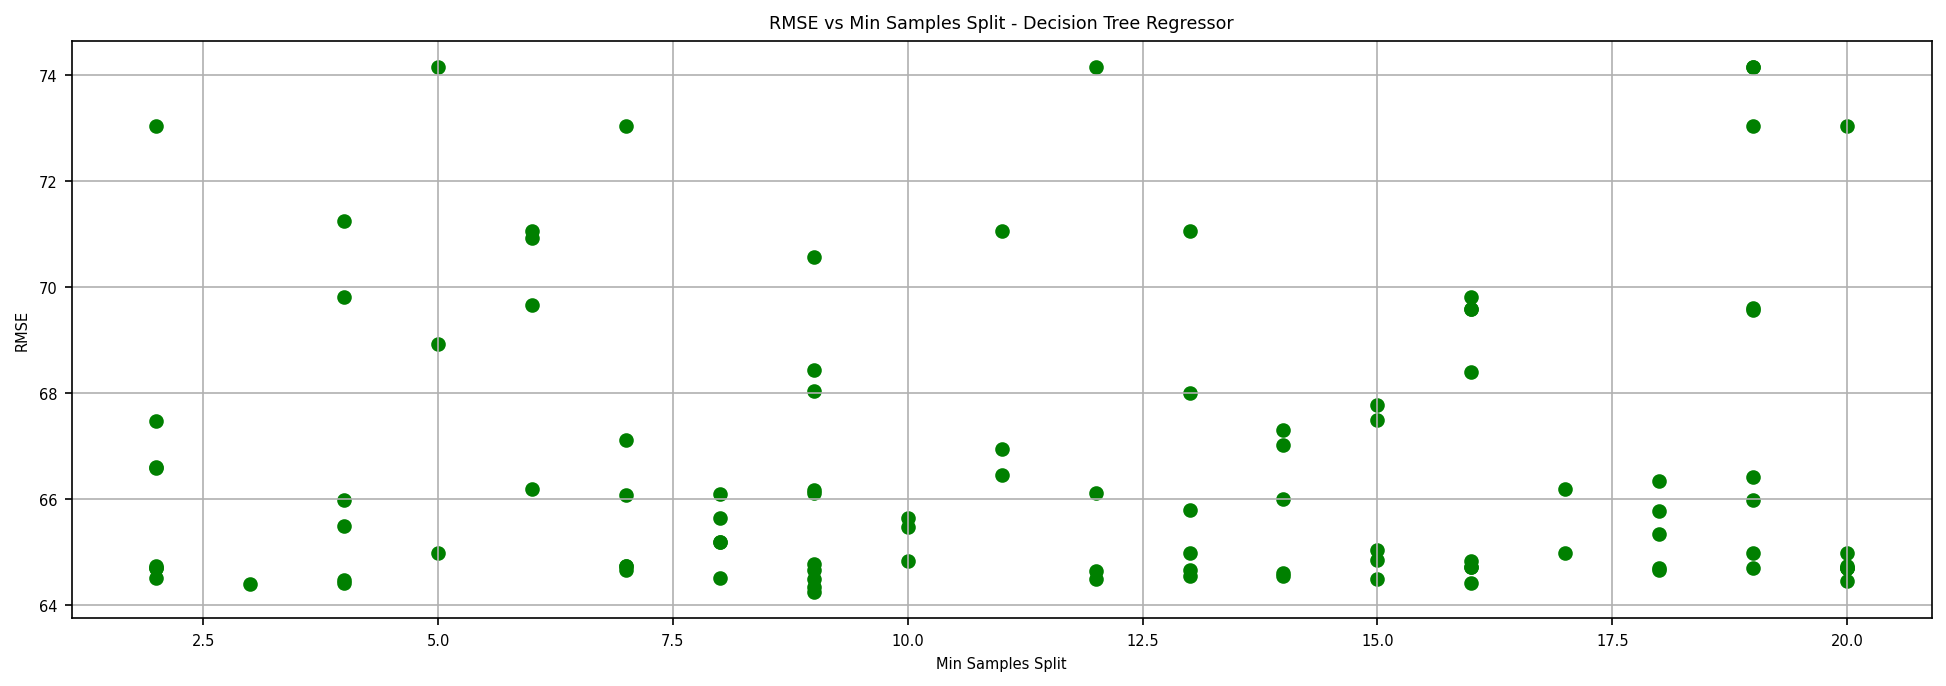

In [ ]:
# Extract values for min_samples_split and scores
param_min_samples_split = results['param_min_samples_split'].data
neg_mean_squared_error = results['mean_test_score']
rmse = np.sqrt(-neg_mean_squared_error)

# Create DataFrame for easy manipulation
rmse_df_split = pd.DataFrame({
'min_samples_split': param_min_samples_split,
'RMSE': rmse
})

# Plotting
plt.figure(figsize=(16, 5))
plt.scatter(rmse_df_split['min_samples_split'], rmse_df_split['RMSE'], marker='o', color='g')
plt.xlabel('Min Samples Split')
plt.ylabel('RMSE')
plt.title('RMSE vs Min Samples Split - Decision Tree Regressor')
plt.grid(True)
plt.show()

In [ ]:
# Định nghĩa không gian tham số cho Grid Search với giá trị hợp lệ
param_grid = {
    'max_depth': [9, 12, 13],  # Độ sâu tối đa của cây (None có nghĩa là không giới hạn)
    'min_samples_split': [6, 9, 19],  # Số mẫu tối thiểu để chia một nút
    'min_samples_leaf': [3, 10, 18]     # Số mẫu tối thiểu trong một nút lá
}

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=param_grid,
    cv=5,          # Số lượng phân chia dữ liệu trong cross-validation
    verbose=1,     # Để hiển thị quá trình tìm kiếm
    n_jobs=-1,     # Sử dụng tất cả các lõi CPU có sẵn
    scoring='neg_mean_squared_error'  )

grid_search.fit(X, y)

# In các tham số tốt nhất và điểm số tương ứng
print(f"Tham số tốt nhất tìm được: {grid_search.best_params_}")
print(f"MSE tương ứng: {grid_search.best_score_}") # best_score_ trong GridSearchCV với scoring='neg_mean_squared_error' là giá trị âm của MSE.

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Tham số tốt nhất tìm được: {'max_depth': 12, 'min_samples_leaf': 18, 'min_samples_split': 19}
MSE tương ứng: -4657.797463828087


In [ ]:
independent = df.columns[~df.columns.isin(["price"])].tolist()
dependent = "price"

# Huấn luyện mô hình Decision Tree Regression
df_results, saved_models, feature_importance_df = decisiontree_model(df, independent, dependent, max_depth=12, min_samples_split=18, min_samples_leaf=9, n_splits=5)
save_model("DecisionTree", "DT-NoOL-Grid", saved_models)

# In kết quả đánh giá
df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE
Fold                                                             
1         34.4    41.83      50.49     62.02      31.92     37.68
2        32.91    43.65      49.29     63.29       32.2     38.01
3        33.72     45.5      50.18     65.74      28.94     50.58
4        32.97    43.93      48.57     65.16      30.73      36.4
5        34.85    43.77      50.98     64.67      33.24     36.61
Mean     33.77    43.74       49.9     64.18      31.41     39.86

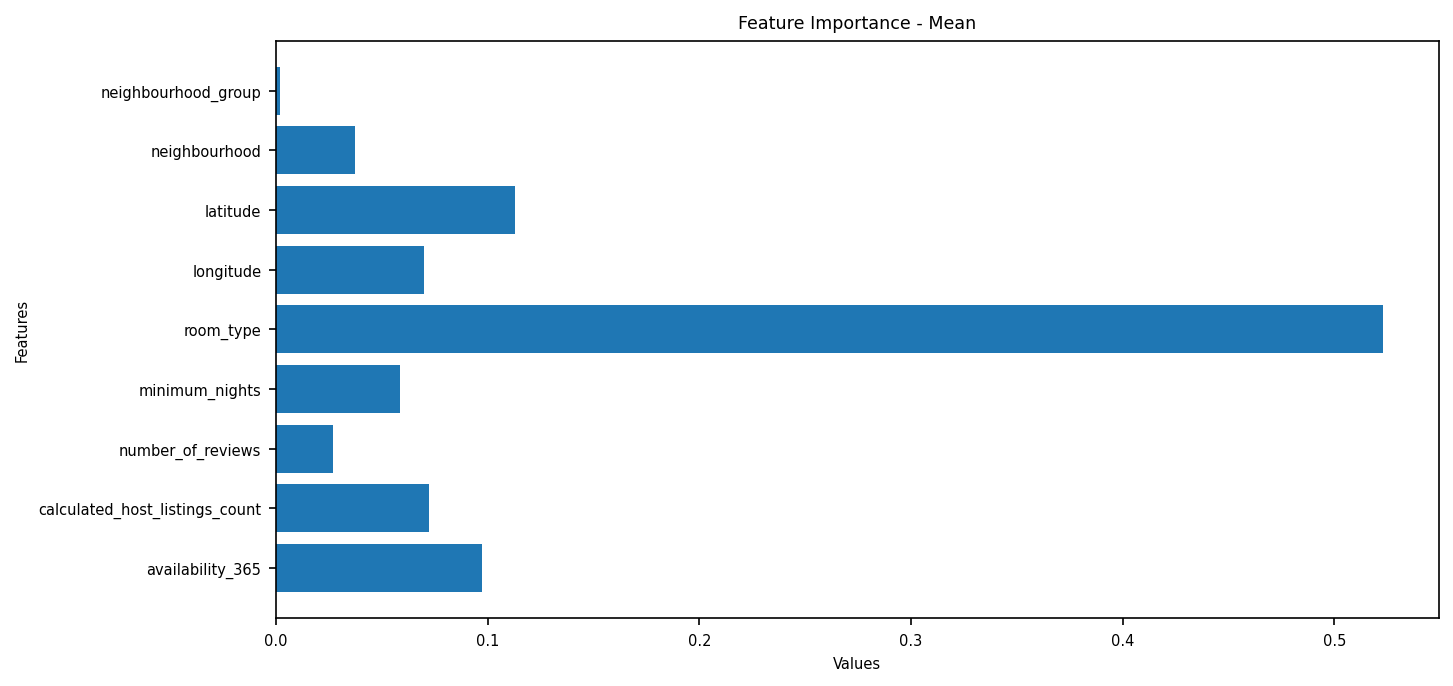

neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
Fold 1               0.0000         0.0357    0.1197     0.0751     0.5122   
Fold 2               0.0001         0.0352    0.1149     0.0756     0.5141   
Fold 3               0.0040         0.0354    0.1041     0.0602     0.5336   
Fold 4               0.0046         0.0383    0.1024     0.0848     0.5200   
Fold 5               0.0002         0.0415    0.1226     0.0532     0.5353   
Mean                 0.0018         0.0372    0.1127     0.0698     0.5230   

        minimum_nights  number_of_reviews  calculated_host_listings_count  \
Fold 1          0.0664             0.0214                          0.0705   
Fold 2          0.0612             0.0306                          0.0764   
Fold 3          0.0564             0.0295                          0.0671   
Fold 4          0.0538             0.0230                          0.0852   
Fold 5          0.0555             0.0307                          0.0629   
Mean            0.0587             0.0270                          0.0724   

        availability_365  
Fold 1            0.0989  
Fold 2            0.0919  
Fold 3            0.1095  
Fold 4            0.0878  
Fold 5            0.0982  
Mean              0.0973

In [ ]:
plot_feature_importance(feature_importance_df, row_index=5)
feature_importance_df

Decision Tree cho fold 4


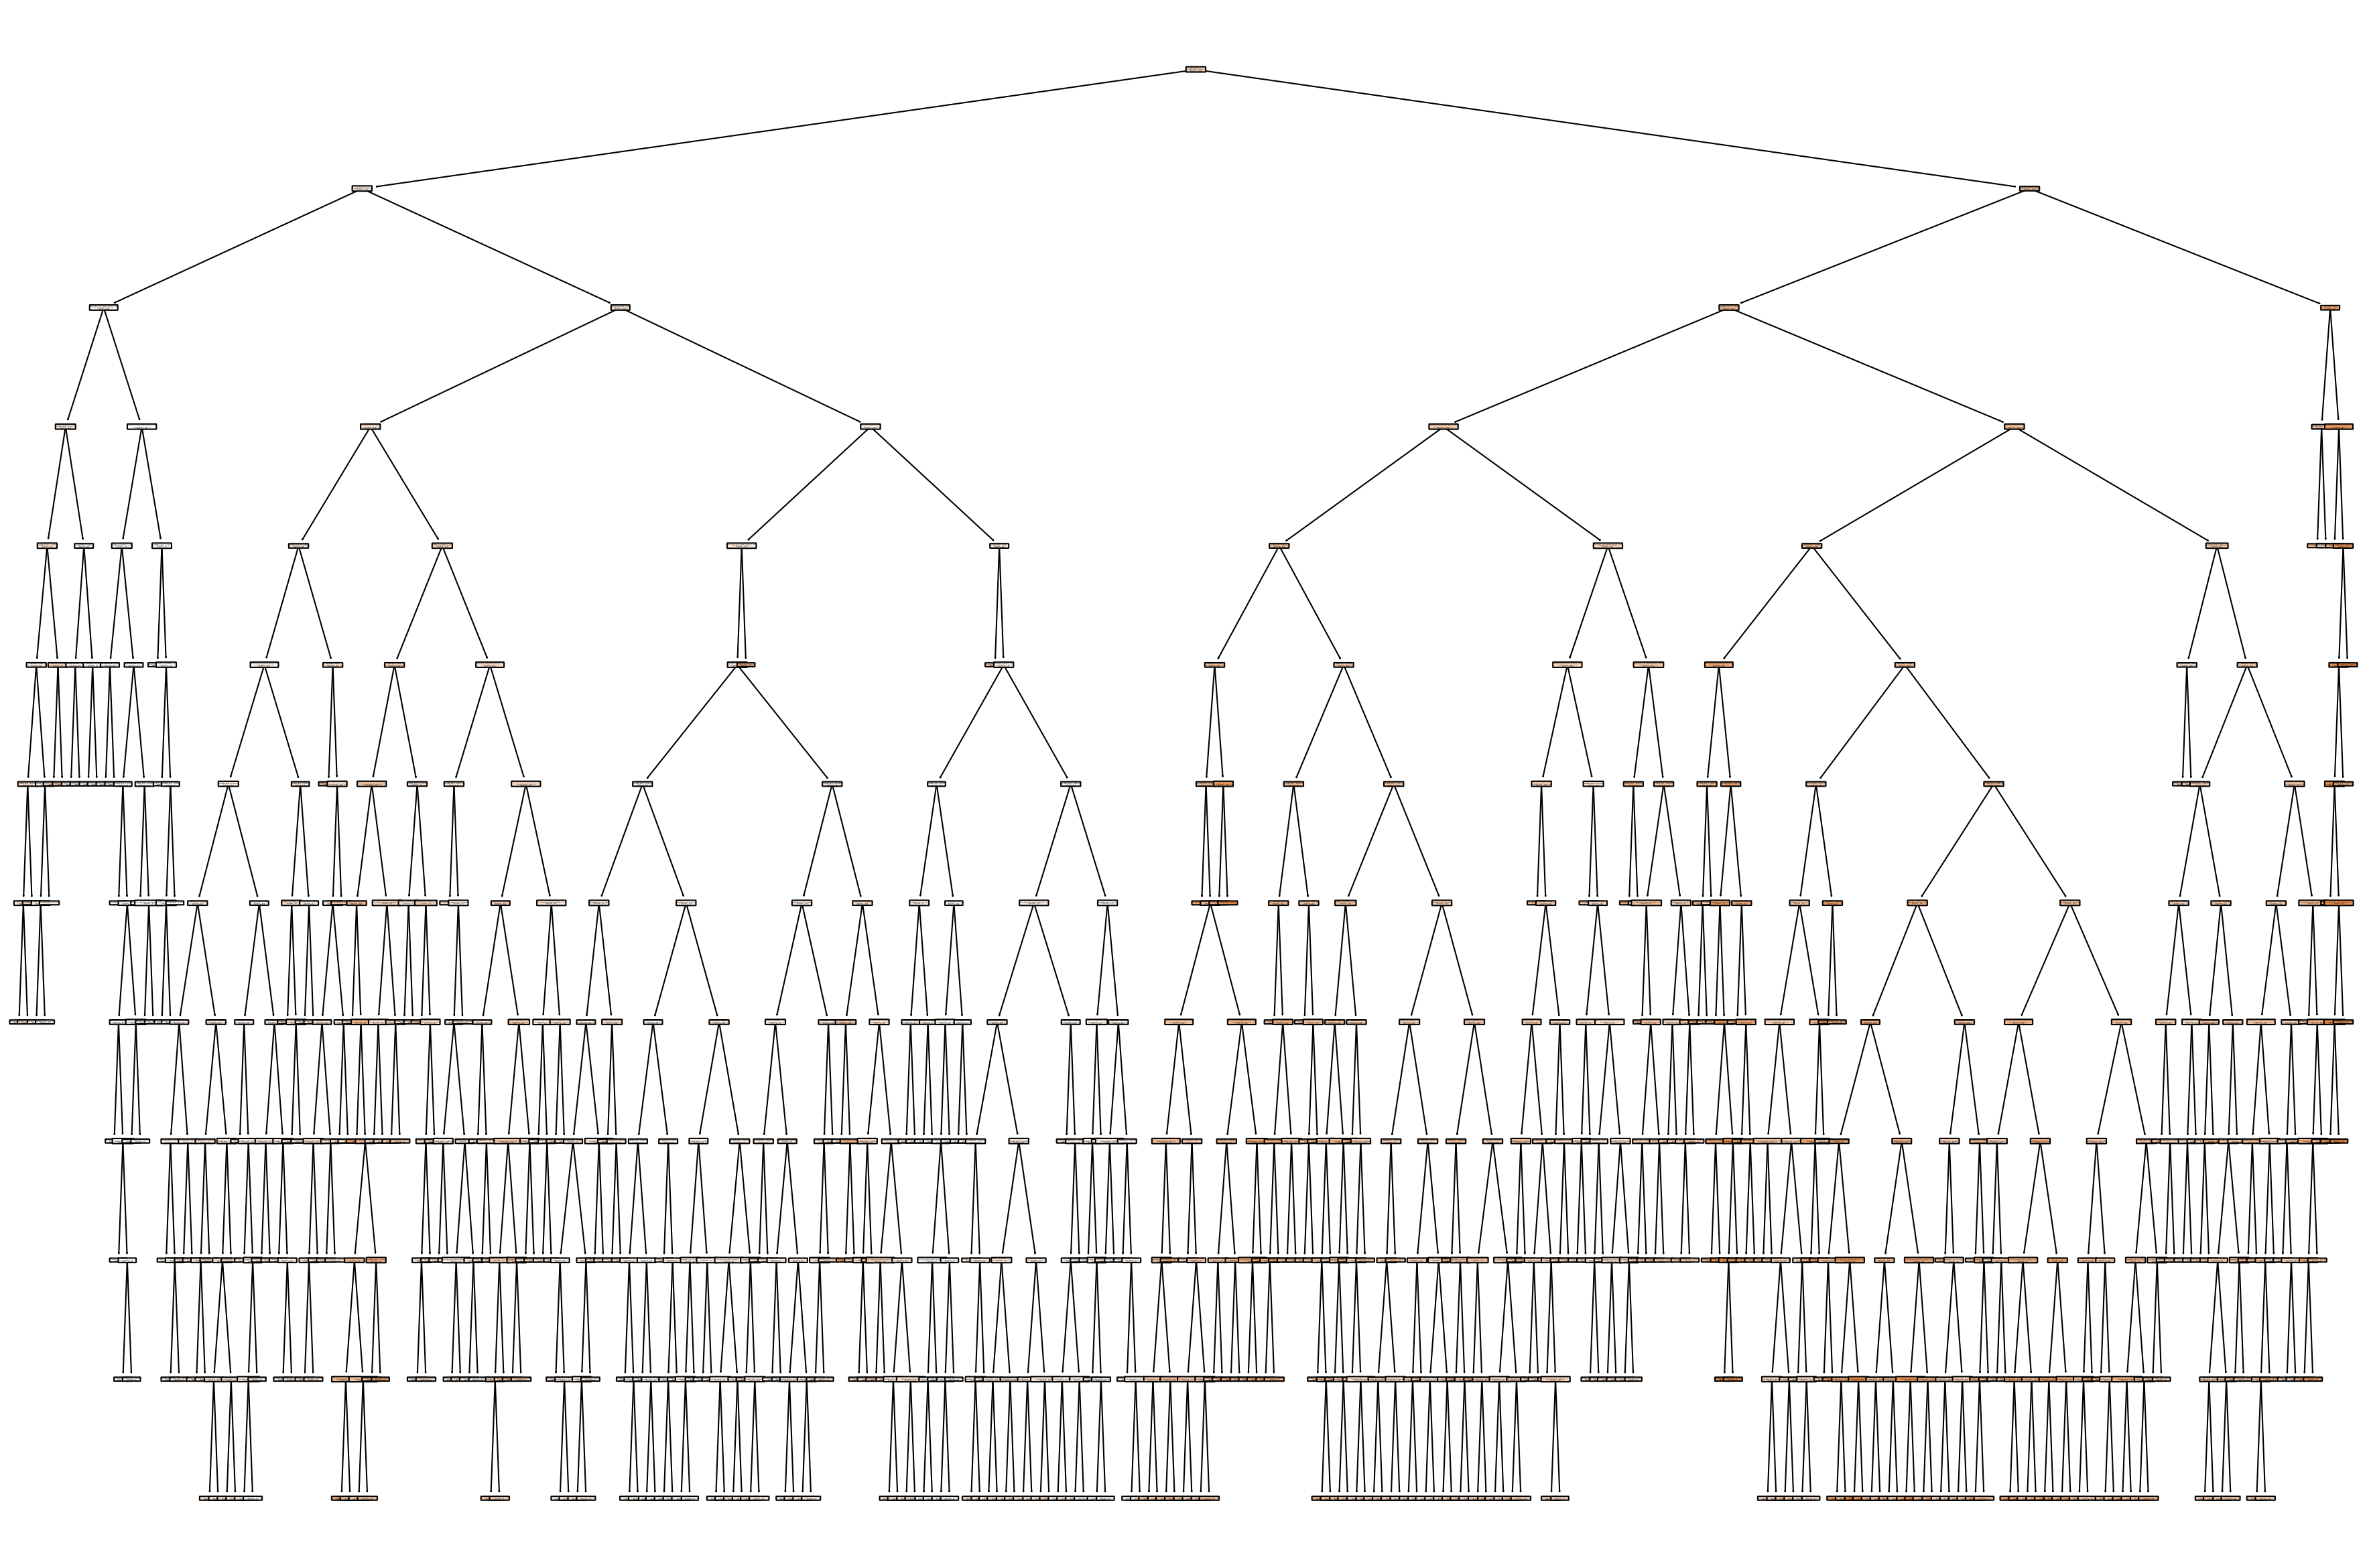

In [ ]:
from sklearn.tree import plot_tree

fold, model = saved_models[3]
print(f"Decision Tree cho fold {fold}")
plt.figure(figsize=(30, 20))
plot_tree(model, feature_names=independent, filled=True, rounded=True)
plt.show()

## Random Forest

In [ ]:
# Tạo mô hình RandomForestRegressor với các tham số tối ưu của Decision Tree
rf_model = RandomForestRegressor(
    max_depth=11,
    min_samples_split=9,
    min_samples_leaf=9,
    random_state=42
)
# Vòng lặp để tìm số lượng n_estimators tối ưu
results = []
n_estimators_list = [10, 50, 100, 200, 300]

for n_estimators in n_estimators_list:
    rf_model.set_params(n_estimators=n_estimators)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results.append((n_estimators, mse))

# In kết quả
for n_estimators, mse in results:
    print(f'n_estimators: {n_estimators}, MSE: {mse}')

# Chọn số lượng n_estimators với MSE thấp nhất
best_n_estimators, best_mse = min(results, key=lambda x: x[1])
print(f'Best n_estimators: {best_n_estimators} with MSE: {best_mse}')

n_estimators: 10, MSE: 3173.8817065677454
n_estimators: 50, MSE: 3095.1310891656663
n_estimators: 100, MSE: 3088.0441226074067
n_estimators: 200, MSE: 3086.5299588995667
n_estimators: 300, MSE: 3086.5619232838185
Best n_estimators: 200 with MSE: 3086.5299588995667


In [ ]:
independent = df.columns[~df.columns.isin(["price"])].tolist()
dependent = "price"

df_results, saved_models, feature_importance_df = randomforest_model(df, independent, dependent, n_estimators=200, max_depth=11, min_samples_split=9, min_samples_leaf=9, n_splits=5)
save_model("RandomForest", "RF-NoOL-Randomized", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE
Fold                                                             
1        34.02    38.06      48.75      54.2       32.6     34.17
2        34.11    39.86       49.1     56.32      33.17     33.81
3        33.99    41.42      48.83     58.53      29.59     51.67
4        33.66     41.7      48.36     59.68      32.23     35.06
5        34.21    39.43      48.93     58.12      32.91     34.26
Mean      34.0    40.09      48.79     57.37       32.1     37.79

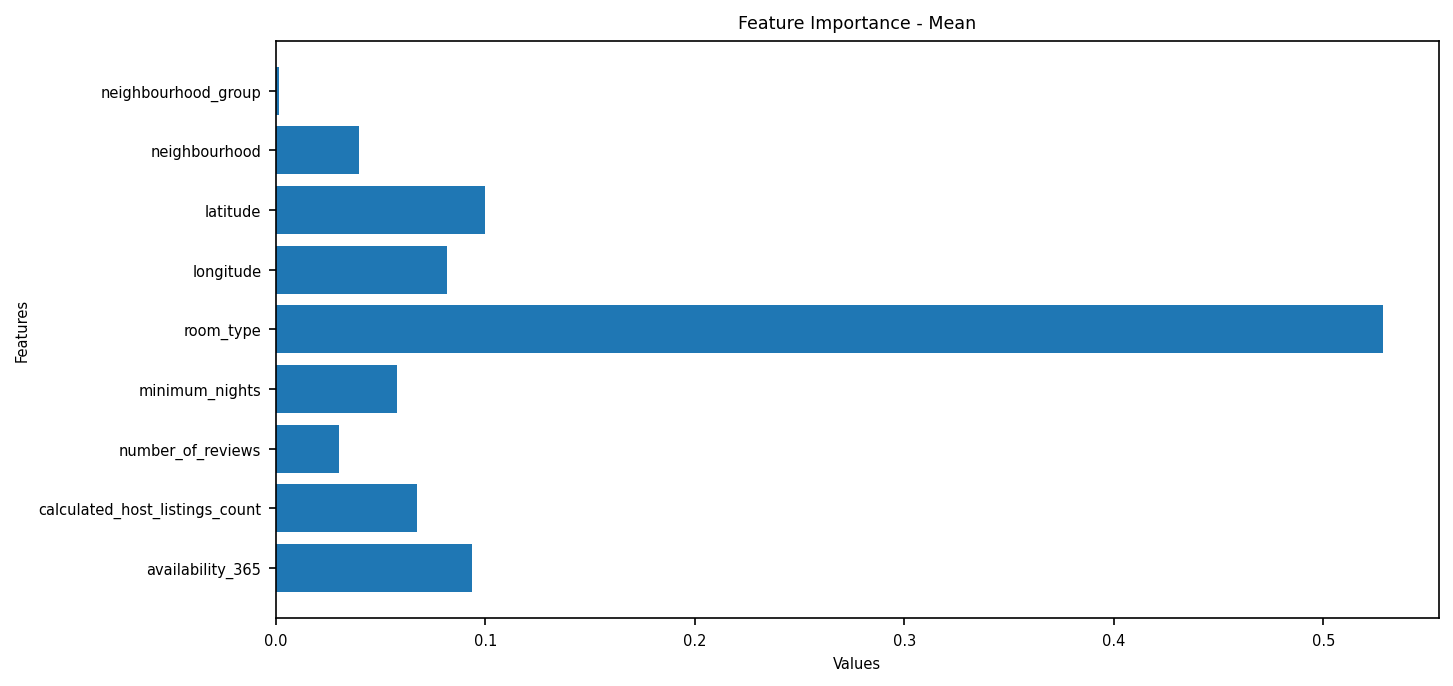

neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
Fold 1               0.0011         0.0327    0.1044     0.0828     0.5157   
Fold 2               0.0015         0.0399    0.1061     0.0831     0.5223   
Fold 3               0.0020         0.0374    0.0963     0.0752     0.5383   
Fold 4               0.0018         0.0446    0.0926     0.0829     0.5359   
Fold 5               0.0008         0.0444    0.0997     0.0834     0.5306   
Mean                 0.0014         0.0398    0.0998     0.0815     0.5286   

        minimum_nights  number_of_reviews  calculated_host_listings_count  \
Fold 1          0.0611             0.0316                          0.0715   
Fold 2          0.0583             0.0282                          0.0660   
Fold 3          0.0592             0.0300                          0.0637   
Fold 4          0.0556             0.0295                          0.0706   
Fold 5          0.0555             0.0307                          0.0650   
Mean            0.0579             0.0300                          0.0674   

        availability_365  
Fold 1            0.0990  
Fold 2            0.0946  
Fold 3            0.0979  
Fold 4            0.0865  
Fold 5            0.0899  
Mean              0.0936

In [ ]:
plot_feature_importance(feature_importance_df, row_index=5)
feature_importance_df

In [ ]:
# Tạo mô hình RandomForestRegressor với các tham số tối ưu của Decision Tree
rf_model = RandomForestRegressor(
    max_depth=12,
    min_samples_split=18,
    min_samples_leaf=9,
    random_state=42
)

# Vòng lặp để tìm số lượng n_estimators tối ưu
results = []
n_estimators_list = [10, 50, 100, 200, 300]

for n_estimators in n_estimators_list:
    rf_model.set_params(n_estimators=n_estimators)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results.append((n_estimators, mse))

# In kết quả
for n_estimators, mse in results:
    print(f'n_estimators: {n_estimators}, MSE: {mse}')

# Chọn số lượng n_estimators với MSE thấp nhất
best_n_estimators, best_mse = min(results, key=lambda x: x[1])
print(f'Best n_estimators: {best_n_estimators} with MSE: {best_mse}')

n_estimators: 10, MSE: 3133.01181356557
n_estimators: 50, MSE: 3071.1548008547597
n_estimators: 100, MSE: 3065.3933093893384
n_estimators: 200, MSE: 3060.834827622448
n_estimators: 300, MSE: 3062.070324805987
Best n_estimators: 200 with MSE: 3060.834827622448


In [ ]:
independent = df.columns[~df_ol.columns.isin(["price"])].tolist()
dependent = "price"

# Huấn luyện mô hình Decision Tree Regression
df_results, saved_models, feature_importance_df = randomforest_model(df, independent, dependent, n_estimators=200, max_depth=12, min_samples_split=18, min_samples_leaf=9, n_splits=5)
save_model("RandomForest", "RF-NoOL-Grid", saved_models)

# In kết quả đánh giá
df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE
Fold                                                             
1        33.28    37.72      47.91     53.91      31.91     33.79
2        33.31    39.51      48.12     55.92      32.39     33.54
3        33.14    41.07      47.83     58.12      28.89      51.2
4        32.77    41.22      47.32     59.25      31.38     34.67
5        33.35    39.08      47.91     57.76      32.13     34.01
Mean     33.17    39.72      47.82     56.99      31.34     37.44

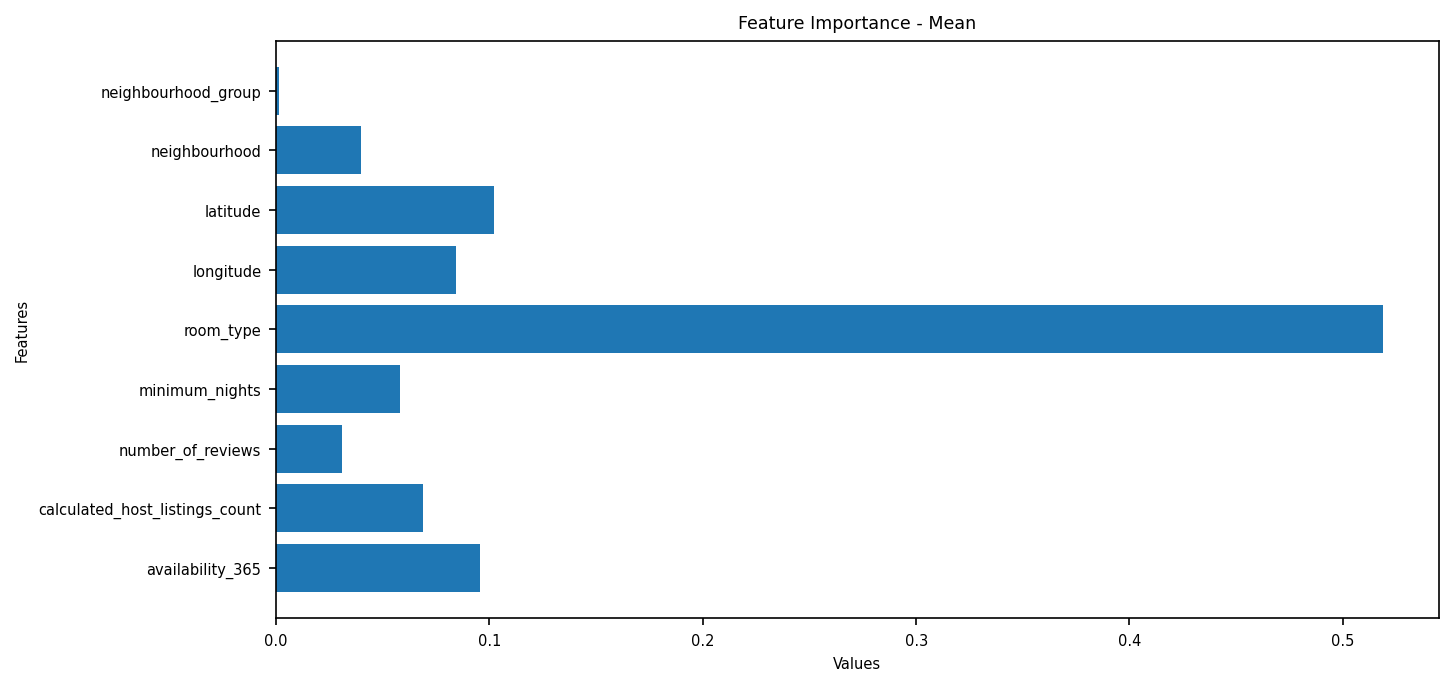

neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
Fold 1               0.0012         0.0328    0.1063     0.0849     0.5075   
Fold 2               0.0016         0.0398    0.1079     0.0853     0.5131   
Fold 3               0.0020         0.0373    0.0984     0.0785     0.5283   
Fold 4               0.0017         0.0445    0.0953     0.0860     0.5254   
Fold 5               0.0008         0.0442    0.1022     0.0864     0.5203   
Mean                 0.0015         0.0397    0.1020     0.0842     0.5189   

        minimum_nights  number_of_reviews  calculated_host_listings_count  \
Fold 1          0.0614             0.0326                          0.0726   
Fold 2          0.0588             0.0292                          0.0677   
Fold 3          0.0595             0.0310                          0.0652   
Fold 4          0.0561             0.0306                          0.0721   
Fold 5          0.0559             0.0317                          0.0665   
Mean            0.0583             0.0310                          0.0688   

        availability_365  
Fold 1            0.1008  
Fold 2            0.0965  
Fold 3            0.0997  
Fold 4            0.0883  
Fold 5            0.0920  
Mean              0.0955

In [ ]:
plot_feature_importance(feature_importance_df, row_index=5)
feature_importance_df